# MT Data-conditioned VAE

CVAE/VAE code trained on Line 1 Central Region, with Line 3 as validation and Line 2 as test 1 (eventually - next step is to get test set(s) finalized and included in code)

In [1]:
# pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [3]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [4]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    # obs_xs = line[:,270:285]
    # print(obs_xs.shape)
    obs_zs = -line[:,286:301]
    print(obs_zs.shape)
    print(cond.shape)
    # obs_total = np.concatenate((obs_xs, obs_zs), axis=1)
    # print(obs_total.shape)
    pred_zs = line[:,348:363]
    return line,cond, obs_zs, pred_zs

In [5]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

# print(obs1)

(16258, 15)
(16258, 30)
(3355, 15)
(3355, 30)
(17419, 15)
(17419, 30)


In [6]:
line94, cond94, obs94, pred94 = import_file('Central_Line94.csv')
print(cond94)

(5748, 15)
(5748, 30)
[[0.027579 0.037342 0.067776 ... 0.001041 0.001032 0.001035]
 [0.029698 0.03982  0.070956 ... 0.001036 0.001028 0.00103 ]
 [0.030611 0.041253 0.073995 ... 0.001036 0.001028 0.00103 ]
 ...
 [0.015569 0.018243 0.027056 ... 0.000411 0.000421 0.000326]
 [0.016965 0.018962 0.025798 ... 0.000391 0.000406 0.000321]
 [0.016929 0.019097 0.025942 ... 0.000459 0.000483 0.00042 ]]


In [7]:
# np.save('Line94_Central.npy', line94)
# np.save('Line94_Central_Conductivity.npy',cond94)
# np.save('Line94_Central_Observations.npy',obs94)

In [8]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths0 = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths0)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
time0 = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])*1e-3
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(time0)
print(nt)
# data are only real
ndata = nt

29
15


In [9]:
depth = np.append(0,depths0)

def format_models(file, depths):
    cond_new = np.zeros((len(file[:,0]),32))
    for i in range(len(file[:,0])):
        x = file[i]
        y = depths
        f = sp.interpolate.interp1d(y,x)
        y_new = [554,573]
        x_new = f(y_new)
        cond_new[i] = np.append(x,x_new)
    return cond_new

cond94_new = format_models(cond94,depth)

print(cond94_new.shape)
print(len(depth))  
# print(len(cond1_new[0]))
# print(cond1_new[1])


(5748, 32)
30


In [10]:
def format_raw(file,times):
    obs_new = np.zeros((len(file[:,0]),16))
    for i in range(len(file[:,0])):
        x = file[i]
        y = times
        f = sp.interpolate.interp1d(y,x)
        y_new = [16.054*1e-3]
        x_new = f(y_new)
        obs_new[i] = np.append(x,x_new)
    return obs_new
    
obs94_new = format_raw(obs94,time0)

print(obs94_new.shape)
print(len(time0))

(5748, 16)
15


In [11]:
from scipy.spatial.distance import cosine

# for i in range(0,1000,10):
#     print(np.mean(cond1[i]-cond1[0]))
#     # plt.plot(cond1[0],depth)
#     # plt.plot(cond1[i],depth)
#     # plt.gca().invert_yaxis()
def compute_moving_average(models, window_size=5):
    """
    Apply moving average to each model (row) in the dataset.
    """
    return np.array([
        np.convolve(model, np.ones(window_size)/window_size, mode='same')
        for model in models
    ])

def select_diverse_models(models, threshold=0.01, metric='mse', window_size=5):
    """
    Select a diverse subset of models based on moving average smoothed values.

    Parameters:
    - models: np.ndarray of shape (N, 30)
    - threshold: float, minimum difference to count as diverse
    - metric: str, 'mse' or 'cosine'
    - window_size: int, size of the moving average window

    Returns:
    - indices: np.ndarray of selected row indices
    """
    smoothed = compute_moving_average(models, window_size)
    selected = [0]  # Always include the first model

    for i in range(1, len(smoothed)):
        prev_model = smoothed[selected[-1]]
        curr_model = smoothed[i]

        if metric == 'mse':
            diff = np.mean((curr_model - prev_model)**2)
        elif metric == 'cosine':
            diff = cosine(curr_model, prev_model)
        else:
            raise ValueError("Unsupported metric. Use 'mse' or 'cosine'.")

        if diff > threshold:
            selected.append(i)

    return np.array(selected)

In [12]:
models = cond1  # or whatever variable holds your data
data = obs1

# Select diverse subset
diverse_indices = select_diverse_models(models, threshold=0.01, metric='mse', window_size=3)

# Extract selected models
diverse_models = models[diverse_indices]
diverse_data = data[diverse_indices]
print(len(diverse_models), len(diverse_data))

print(f"Selected {len(diverse_indices)} diverse models from {len(models)} total")

885 885
Selected 885 diverse models from 16258 total


In [13]:
cond1_sampled = format_models(diverse_models,depth)
obs1_sampled = format_raw(diverse_data, time0)

print(cond1_sampled.shape)
print(obs1_sampled.shape)

(885, 32)
(885, 16)


In [14]:
np.save('Sampled_Line1_Central_Conductivity.npy',cond1_sampled)
np.save('Sampled_Line1_Central_Observations.npy',obs1_sampled)

In [15]:
depths=np.append(depths0,[554,573])
print(depths.shape)

# np.save('Line94_Central_Conductivity.npy',cond94_new)

(31,)


In [16]:
times = np.append(time0,16.054*1e-3)
times.sort()
print(len(times))

# np.save('Line94_Central_Observations.npy',obs94_new)

16


In [17]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [18]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='mae',
                   data_loss_type='mae'
                  )

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [19]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Sampled_Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test_log = preprocess('Line2_Central_Conductivity.npy')
x_test_log94 = preprocess('Line94_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw = np.load('Sampled_Line1_Central_Observations.npy')
x_validate_raw = np.load('Line3_Central_Observations.npy')
x_test_raw = np.load('Line2_Central_Observations.npy')
print(x_test_raw.shape)
x_test_raw94 = np.load('Line94_Central_Observations.npy')
print(x_test_raw94.shape)
#print(x_train_raw_log)

# x_train_raw = network.model_to_tanhs(x_train_raw_log)
# x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
# x_test1_raw = network.model_to_tanhs(x_test1_raw_log)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test = network.model_to_tanhs(x_test_log)
x_test94 = network.model_to_tanhs(x_test_log94)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

AuEM_models1 = np.load('Sampled_Line1_Central_Conductivity.npy')
AuEM_models2 = np.load('Line2_Central_Conductivity.npy')
AuEM_models3 = np.load('Line3_Central_Conductivity.npy')

(3355, 16)
(5748, 16)


In [20]:
print(x_train.shape)
print(x_validate.shape)
print(x_train_raw.shape)
print(x_validate_raw.shape)

x_train1 = x_train
# print(x_train1)
x_validate1 = x_validate[0:3000,]
x_train_raw1 = x_train_raw
x_validate_raw1 = x_validate_raw[0:3000,]
# x_test_raw1 = x_test_raw[0:1000,]
# print(x_train_raw1)
# plt.plot(x_train_raw1[0],np.append(0,depths))

(885, 32, 1)
(17419, 32, 1)
(885, 16)
(17419, 16)


In [21]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
# print(train_data)
# print("train data", train_data.shape)
# print('.........')


raw_train = np.asarray(x_train_raw1.T)
print(np.shape(raw_train[:,0]))
print(times)
raw_train_T = raw_train*1e-15
raw_train_data = np.gradient(raw_train_T,times, axis=0)
raw_train_data = -np.abs(raw_train_data).T
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)
print(raw_train_data[0])
raw_validate = np.asarray(x_validate_raw1.T)
raw_validate_T = raw_validate*1e-15
raw_validate_data = np.gradient(raw_validate_T,times, axis=0)
raw_validate_data = -np.abs(raw_validate_data).T
validate_data = x_validate1[:,:,0]
# raw_validate_data = -x_validate_raw1

raw_test = np.asarray(x_test_raw.T)
raw_test_T = raw_test*1e-15
print(raw_test_T.shape)
raw_test_data = np.gradient(raw_test_T,times, axis=0)
raw_test_data = -np.abs(raw_test_data).T

raw_test94 = np.asarray(x_test_raw94.T)
raw_test94_T = raw_test94*1e-15
print(raw_test94_T.shape)
raw_test_data94 = np.gradient(raw_test94_T,times, axis=0)
raw_test_data94 = -np.abs(raw_test_data94).T

# print(raw_validate_data)
# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

(16,)
[1.3000e-05 3.9000e-05 6.5000e-05 1.0400e-04 1.6900e-04 2.7300e-04
 4.4300e-04 7.0300e-04 1.0940e-03 1.6930e-03 2.6300e-03 4.1020e-03
 6.4060e-03 9.9610e-03 1.6054e-02 1.6055e-02]
raw_train_data (885, 16)
[-3.56506538e-11 -2.61857885e-11 -1.42078564e-11 -9.22796026e-12
 -6.33067352e-12 -4.33213139e-12 -2.95920500e-12 -2.04432837e-12
 -1.40115052e-12 -9.33316057e-13 -5.82337001e-13 -3.35067112e-13
 -1.78962703e-13 -8.86255387e-14 -5.08564564e-14 -5.08731539e-14]
(16, 3355)
(16, 5748)


In [22]:
# plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [23]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [24]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
# plt.plot(train_data[0],np.append(0,depths))

(885, 32)
(885, 16)


In [25]:
# # Create batches and shuffle
BATCH_SIZE = 20

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
print('data_std',rel_data_std)

data_std [0.16293189 0.13683728 0.0923168  0.04228372 0.00178344 0.01963309
 0.02518098 0.02877773 0.03943639 0.05144532 0.04972434 0.01785738
 0.05374476 0.14629787 0.23666232 0.31472983 0.37828423 0.42787914
 0.46510331 0.49193975 0.51047667 0.522704   0.53037303 0.53492818
 0.53747906 0.53881977 0.53947837 0.539779   0.53990336 0.53993911
 0.539914   0.53992578]


In [26]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [27]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=0.01,
                   model_loss_type='mae',
                   data_loss_type='mae'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [28]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, 32))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
print(network.predict_tanh(random_train))
# predict their data
# print(n_cells)
random_data = network.predict_tanh(random_train.reshape(16, 32, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
print('latent_input',latent_input)
# print('n_data',network.n_data)
random_data1 = random_data[:,:16]
data_input = tf.reshape(random_data1,(16,network.n_time))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

tf.Tensor(
[[-6.45190706e-11 -1.99556881e-11 -1.22700435e-11 -8.18726077e-12
  -5.61505443e-12 -3.98589885e-12 -2.82299423e-12 -1.95049424e-12
  -1.28353296e-12 -8.12762509e-13 -5.14624042e-13 -3.17465807e-13
  -1.73849243e-13 -8.02676136e-14 -2.78755290e-14 -2.78712498e-14]
 [-6.78344880e-11 -2.36647056e-11 -1.45413915e-11 -9.59303383e-12
  -6.51341654e-12 -4.60267631e-12 -3.25611825e-12 -2.25052507e-12
  -1.48326132e-12 -9.42686467e-13 -5.99233553e-13 -3.69080797e-13
  -2.00580289e-13 -9.16278433e-14 -3.14085678e-14 -3.14036889e-14]
 [-6.13472745e-11 -2.48611028e-11 -1.60002133e-11 -1.08217714e-11
  -7.42273083e-12 -5.21726369e-12 -3.61701901e-12 -2.43941239e-12
  -1.59656077e-12 -1.04466934e-12 -6.87385858e-13 -4.19909143e-13
  -2.19147793e-13 -9.52074926e-14 -3.08144759e-14 -3.08094580e-14]
 [-6.26491012e-11 -2.02407154e-11 -1.26869652e-11 -8.62816762e-12
  -6.02343132e-12 -4.30064317e-12 -3.00624564e-12 -2.02758643e-12
  -1.31595754e-12 -8.49977640e-13 -5.62819756e-13 -3.57609748e

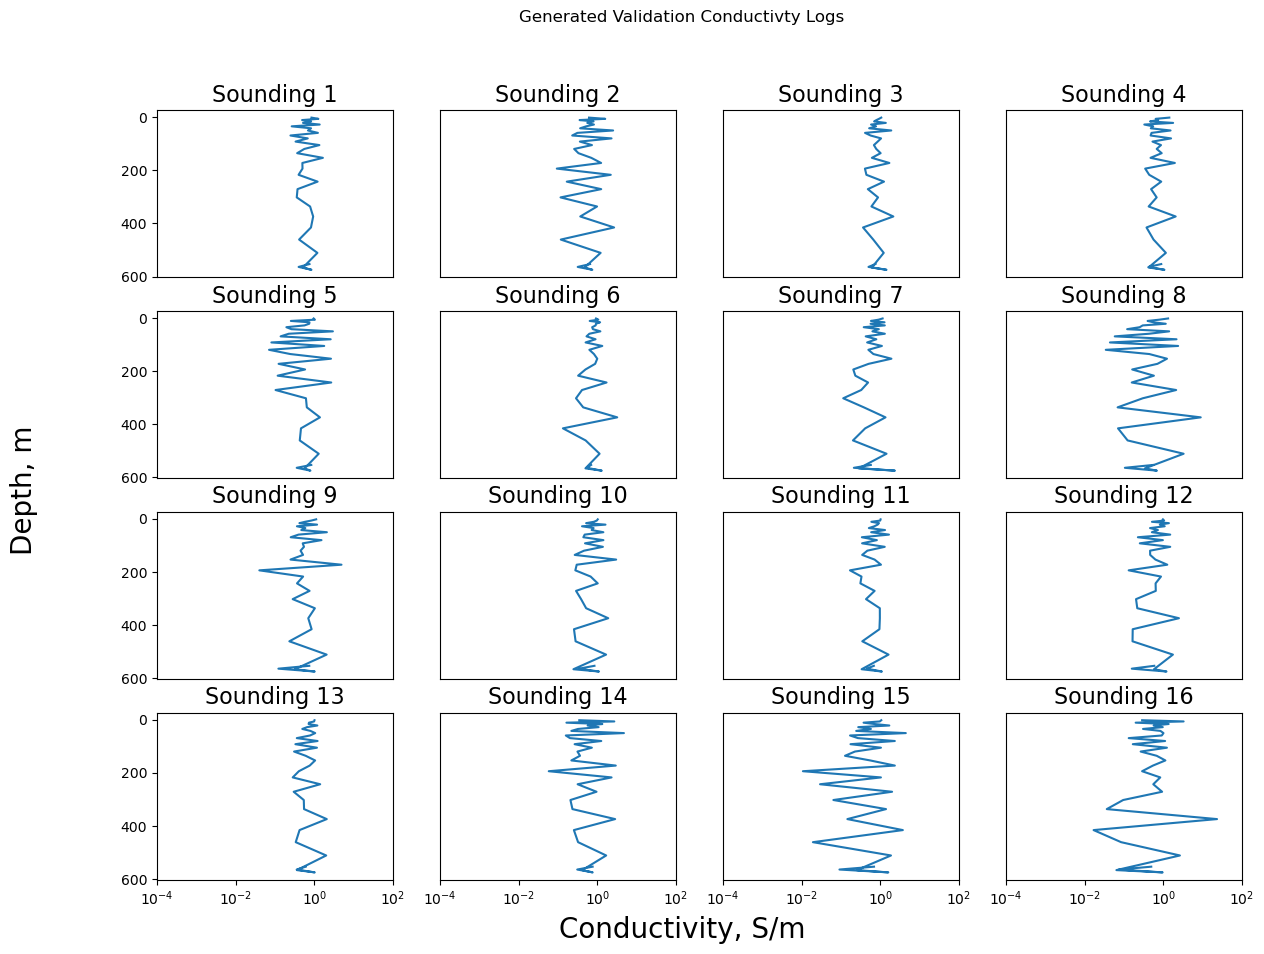

57431

<Figure size 640x480 with 0 Axes>

In [29]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

In [30]:
optimizer = tf.keras.optimizers.Adam(0.003, 0.5)

# Train

In [31]:
epochs = 40

In [32]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(train_x)
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, train_term[0], train_term[1], train_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))


Epoch: 1, Data misfit: 6.383e-11, Reconstruction: 354.2, KL: 0.2672, Elapsed 76.1 s
Epoch: 2, Data misfit: 1.236e-10, Reconstruction: 329.6, KL: 0.3563, Elapsed 107.5 s
Epoch: 3, Data misfit: 1.015e-10, Reconstruction: 310.6, KL: 0.3888, Elapsed 140.1 s
Epoch: 4, Data misfit: 9.842e-11, Reconstruction: 236.9, KL: 0.4142, Elapsed 83.53 s
Epoch: 5, Data misfit: 5.911e-11, Reconstruction: 246.5, KL: 0.5225, Elapsed 132.3 s
Epoch: 6, Data misfit: 5.565e-11, Reconstruction: 206.4, KL: 0.5396, Elapsed 70.63 s
Epoch: 7, Data misfit: 8.234e-11, Reconstruction: 184.7, KL: 0.5878, Elapsed 72.23 s
Epoch: 8, Data misfit: 5.261e-11, Reconstruction: 116.7, KL: 0.5765, Elapsed 71.04 s
Epoch: 9, Data misfit: 6.76e-11, Reconstruction: 191.1, KL: 0.5894, Elapsed 70.75 s
Epoch: 10, Data misfit: 6.314e-11, Reconstruction: 135.7, KL: 0.5949, Elapsed 71.26 s
Epoch: 11, Data misfit: 7.496e-11, Reconstruction: 148.8, KL: 0.6051, Elapsed 71.53 s
Epoch: 12, Data misfit: 5.864e-11, Reconstruction: 107.0, KL: 0.6

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load networks

In [33]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [34]:
loss_terms = np.load(run+'/losses.npy')

In [35]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [36]:
plt.rcParams.update({'font.size': 18})

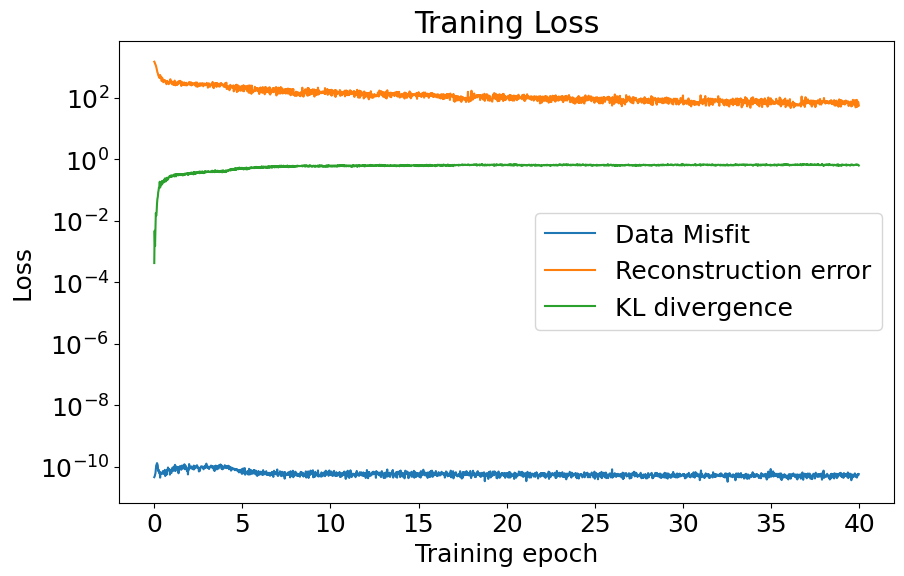

In [37]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data Misfit','Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

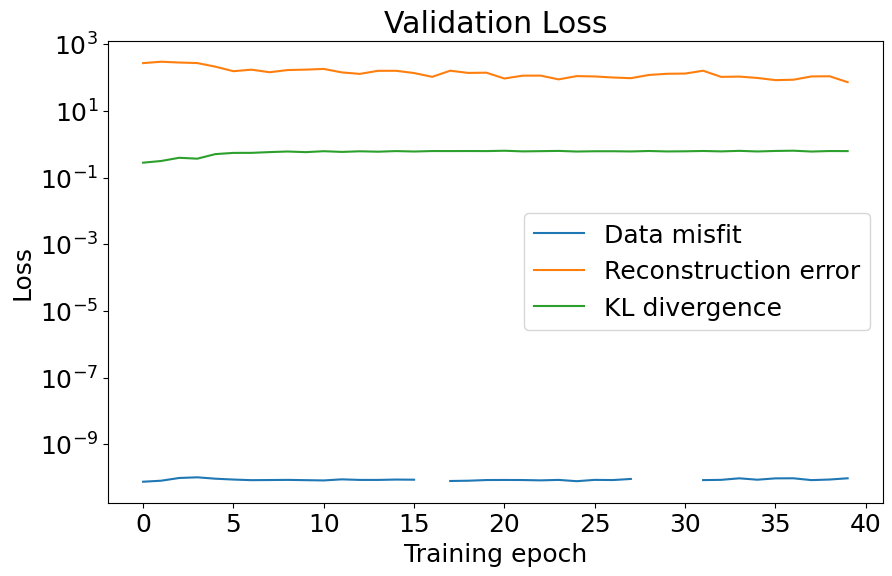

In [38]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

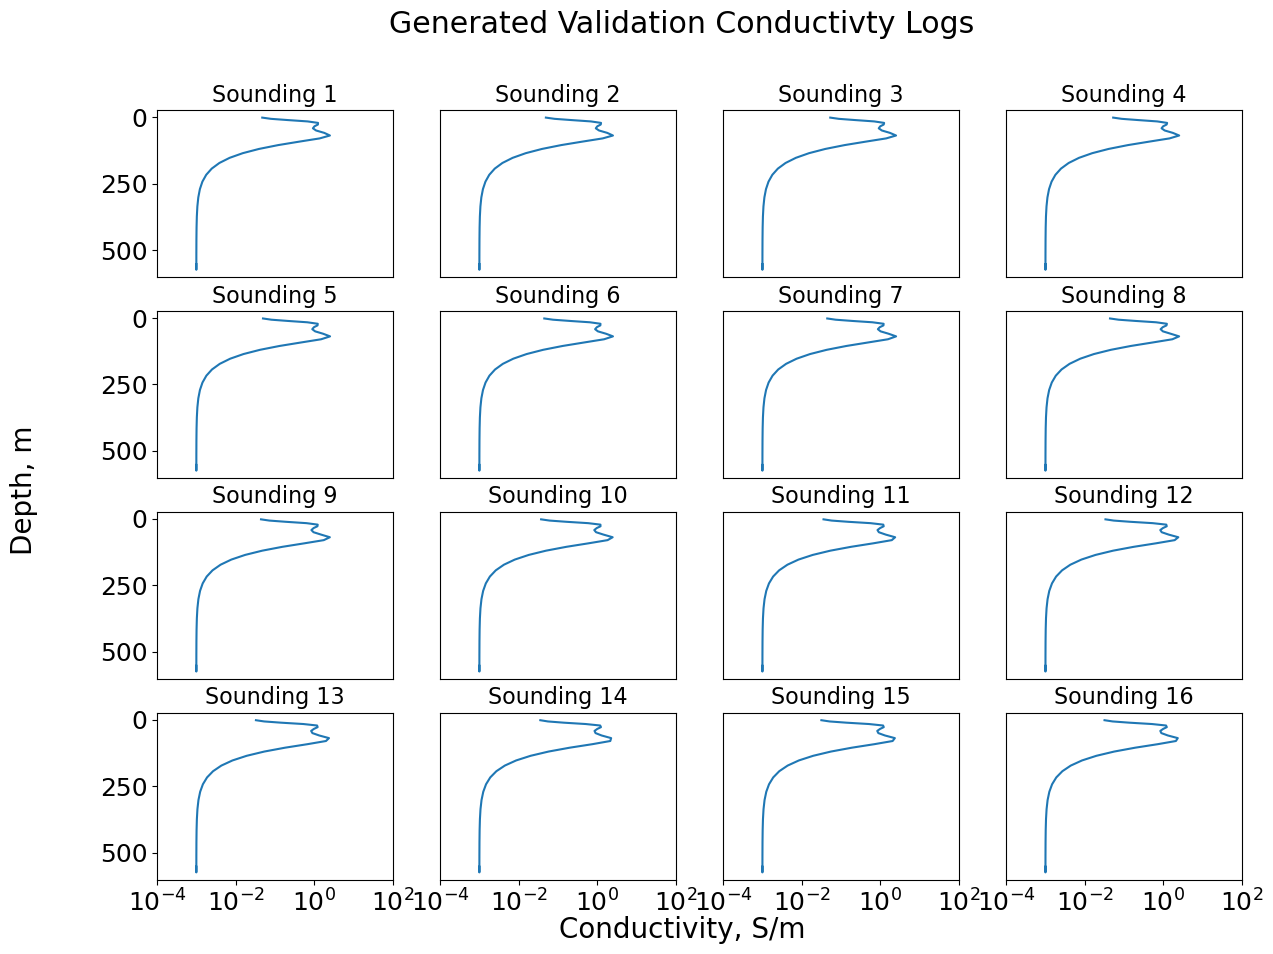

In [39]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=False)

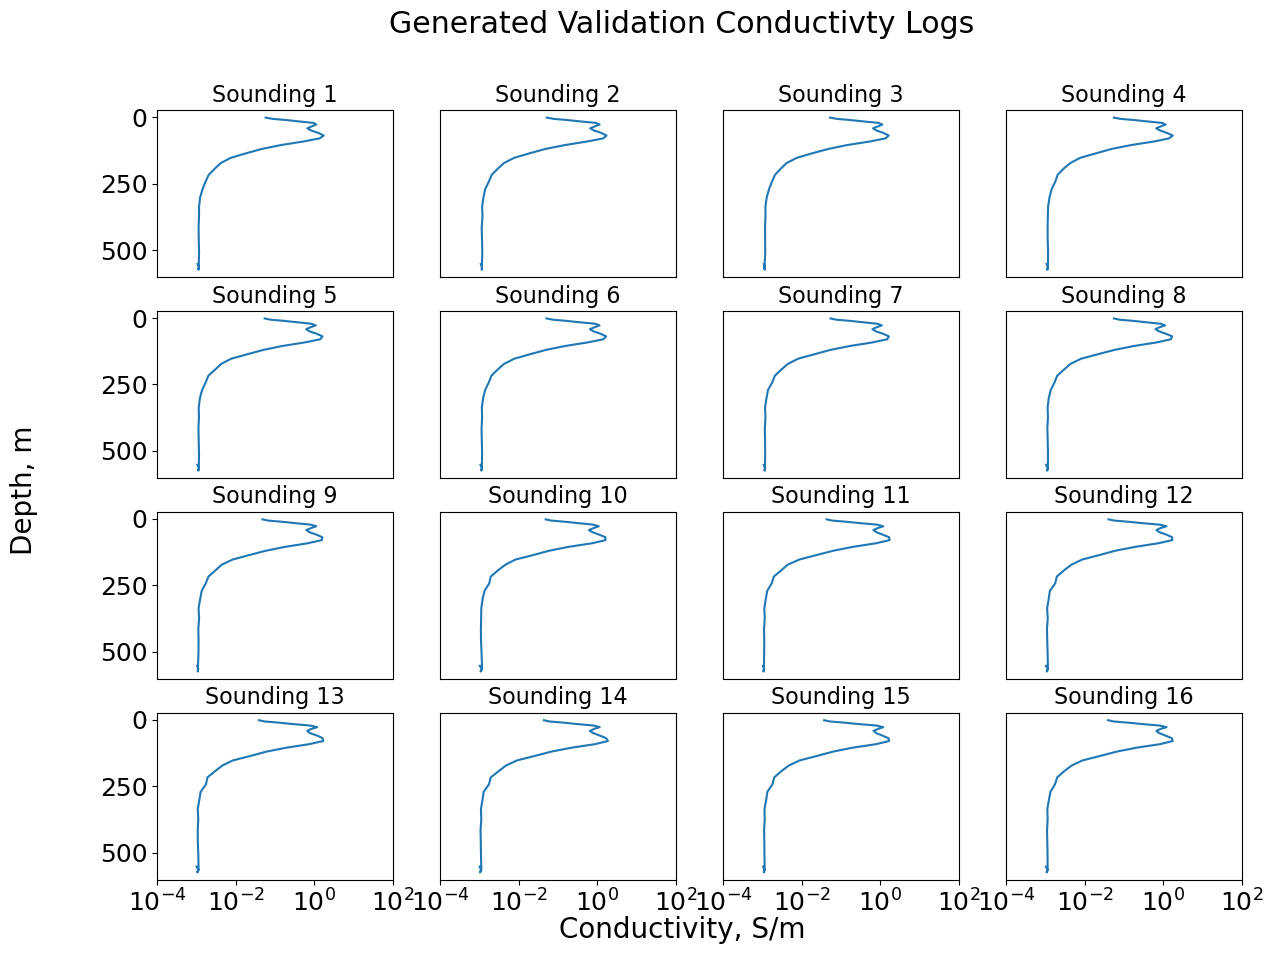

In [40]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
network.plot_models(latent=zmd)

In [ ]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

zmd_tanhs = network.decode(zmd, apply_tanh=True)
zmd_samples = zmd_tanhs.shape[0]
zmd_tanhs = np.reshape(zmd_tanhs, (zmd_samples, network.n_model))
zmd_logs = np.exp(network.tanhs_to_model(zmd_tanhs))
# zmdlogs = np.exp(zmd_logs)

true_validate = np.exp(network.tanhs_to_model(x_validate[0:16]))

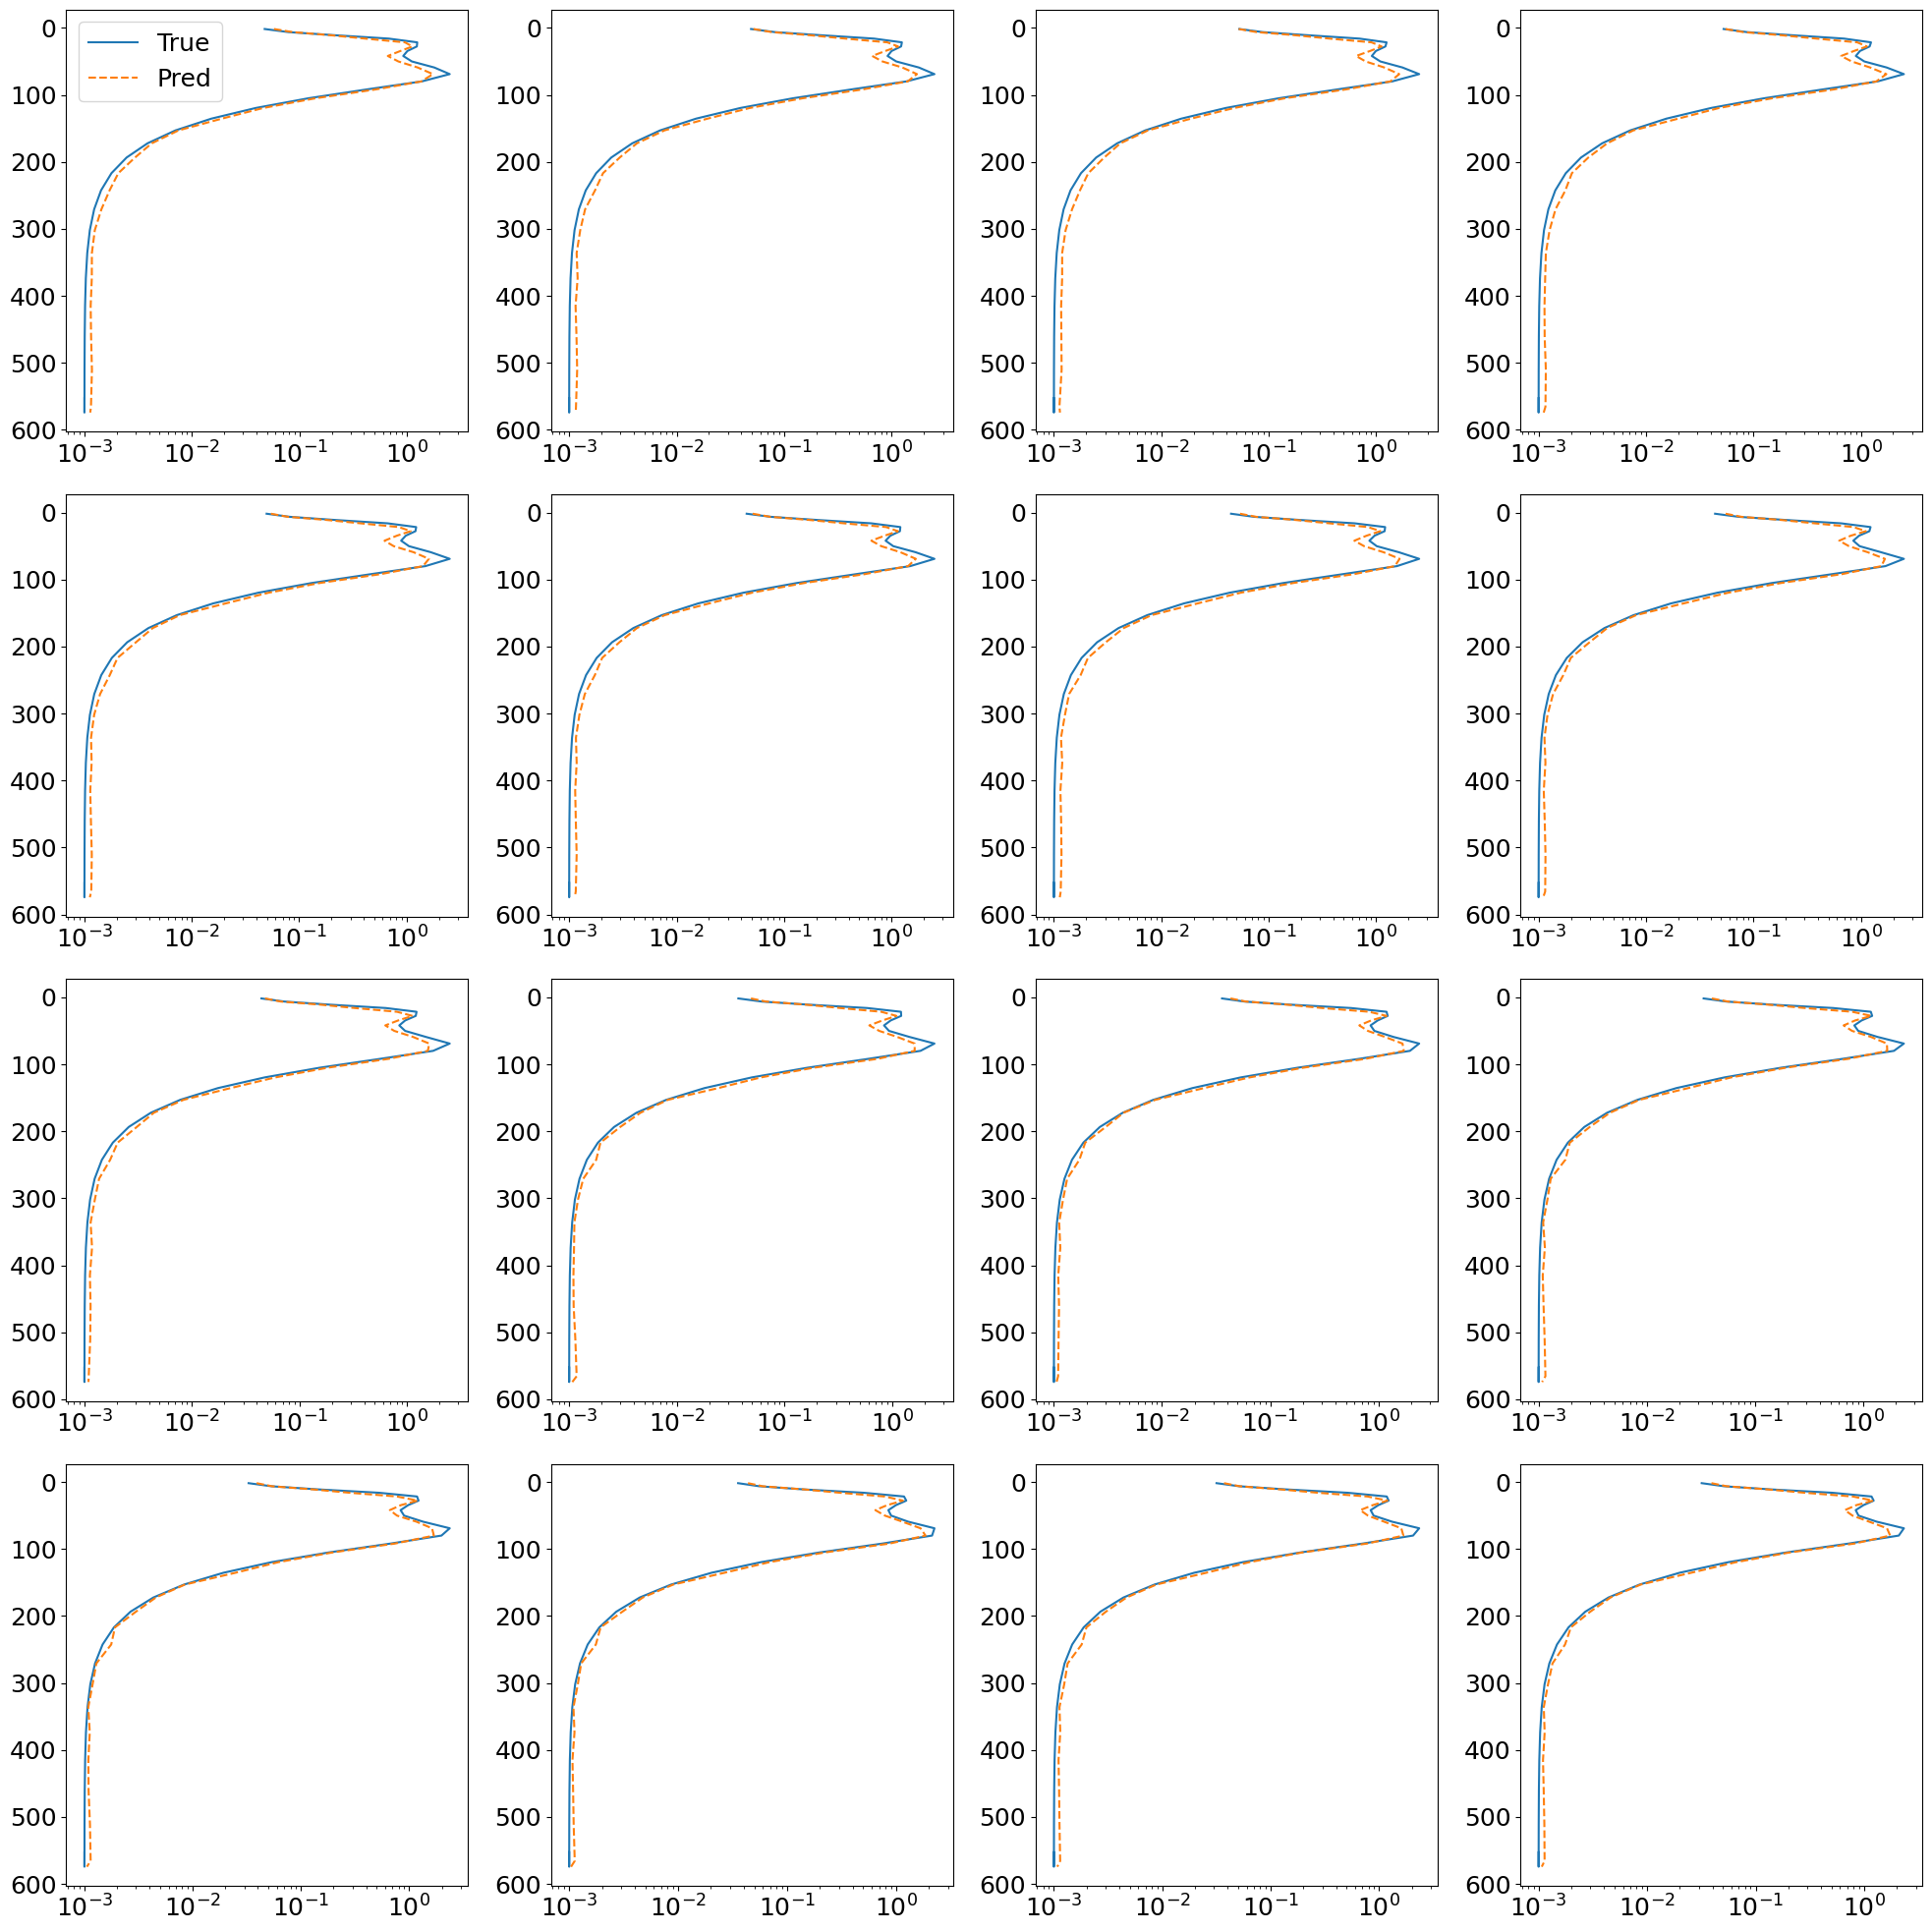

In [138]:
#Why does x2 on the predicted make it match better???
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_validate[i], plot_depths, label='True')
    plt.plot(zmd_logs[i][:-2], plot_depths[:-2], label='Pred', linestyle='--')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

In [43]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [44]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)
print(tanhs)

tf.Tensor(
[[[-0.22251771]
  [-0.19115803]
  [-0.12814543]
  [-0.06962181]
  [-0.00322866]
  [ 0.00919901]
  [-0.01084464]
  [-0.03189479]
  [-0.0142347 ]
  [ 0.01802309]
  [ 0.04366017]
  [ 0.02434682]
  [-0.05227199]
  [-0.15285754]
  [-0.24034342]
  [-0.309856  ]
  [-0.38247892]
  [-0.4272421 ]
  [-0.45527104]
  [-0.4832162 ]
  [-0.497864  ]
  [-0.5115327 ]
  [-0.5225526 ]
  [-0.5274499 ]
  [-0.5276005 ]
  [-0.5295096 ]
  [-0.5287899 ]
  [-0.5273822 ]
  [-0.5289889 ]
  [-0.53024465]
  [-0.52848005]
  [-0.53399074]]

 [[-0.2312338 ]
  [-0.20054215]
  [-0.13697341]
  [-0.07695429]
  [-0.00718763]
  [ 0.01079731]
  [-0.01063292]
  [-0.03251185]
  [-0.01536456]
  [ 0.01788227]
  [ 0.04240351]
  [ 0.02688781]
  [-0.04863895]
  [-0.1489229 ]
  [-0.23731497]
  [-0.30817592]
  [-0.38040075]
  [-0.42657515]
  [-0.4553086 ]
  [-0.48323366]
  [-0.49660894]
  [-0.51323086]
  [-0.5213608 ]
  [-0.5273935 ]
  [-0.5257486 ]
  [-0.5291975 ]
  [-0.5276422 ]
  [-0.5265201 ]
  [-0.52849627]
  [-0.52885

In [45]:
minmax(x_test[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.5399266299885006>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.03254183984457575>)

(16, 36)


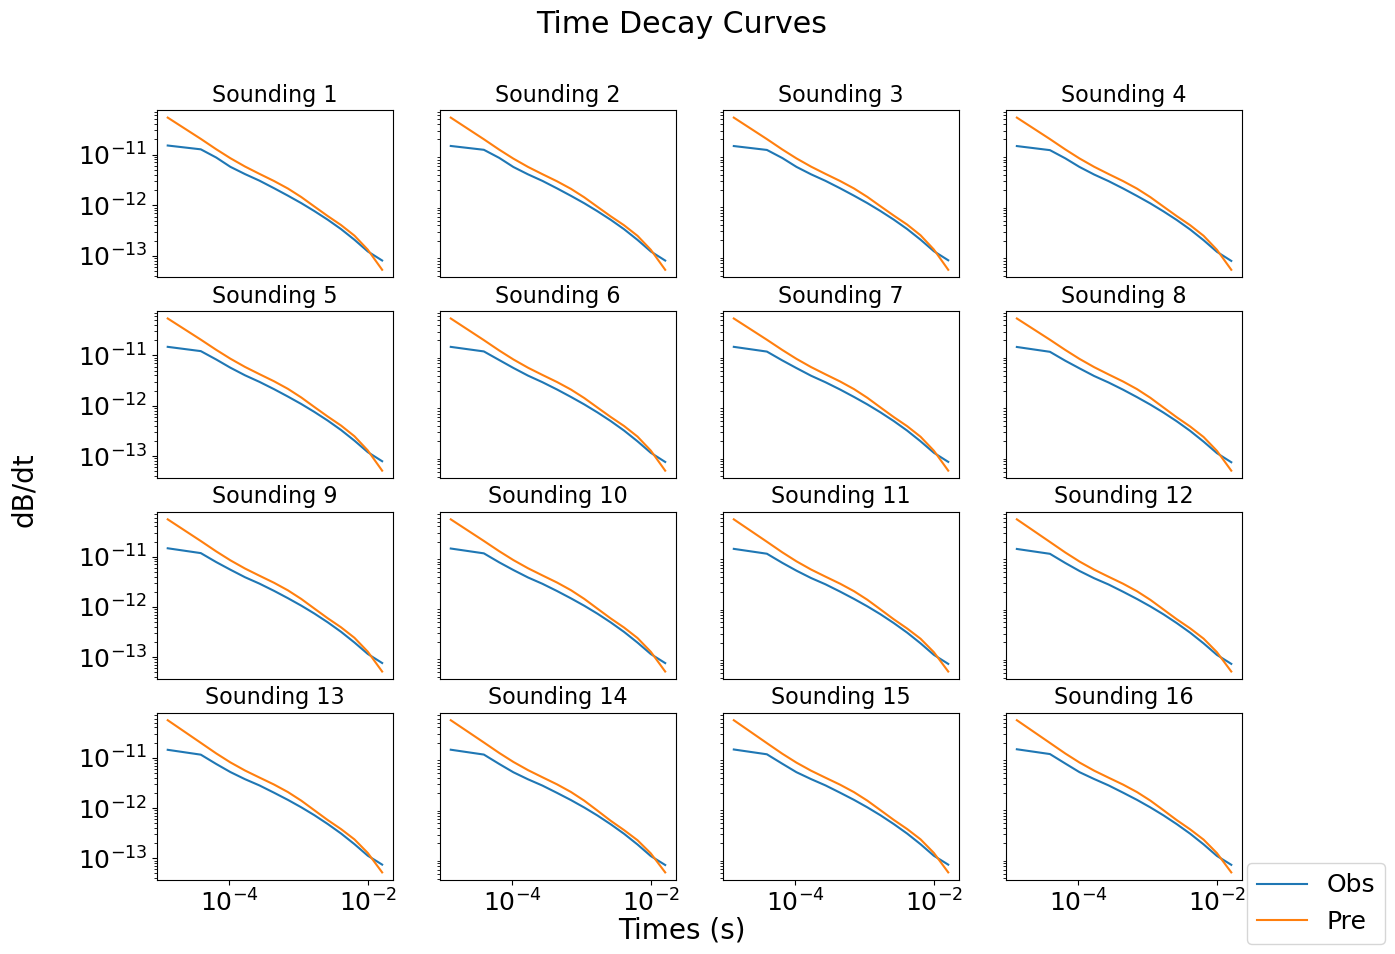

In [46]:
print(zmd.shape)
network.plot_data(latent=zmd)

# d_obs is from validation seta

d_obs: (16, 16)
d_pre: (16, 16)
data_std: (1, 32, 1)
n_time: 16
d_std: (1, 16)
data tf.Tensor(
[[-3.83516968e-11 -7.66986474e-12 -3.98295112e-12 -2.73915743e-12
  -1.68408256e-12 -1.10284351e-12 -8.37194897e-13 -5.90367815e-13
  -3.50526791e-13 -1.77017147e-13 -9.36219418e-14 -6.80527954e-14
  -4.28889780e-14 -1.00691347e-14 -2.79774305e-14 -2.80113931e-14]
 [-3.92315347e-11 -7.69840181e-12 -3.93191729e-12 -2.65012101e-12
  -1.64581196e-12 -1.08466404e-12 -8.21402408e-13 -5.77292662e-13
  -3.39707537e-13 -1.69601204e-13 -8.93778866e-14 -6.58398574e-14
  -4.19601962e-14 -9.76868868e-15 -2.77425821e-14 -2.77762873e-14]
 [-3.94141456e-11 -7.93743283e-12 -4.09784446e-12 -2.70446339e-12
  -1.70766396e-12 -1.13004398e-12 -8.48240965e-13 -5.98514402e-13
  -3.57799185e-13 -1.86044377e-13 -1.04028711e-13 -7.54350196e-14
  -4.55289425e-14 -9.85611603e-15 -2.82377678e-14 -2.82712256e-14]
 [-3.91570734e-11 -8.03233261e-12 -4.21812238e-12 -2.70377514e-12
  -1.72127286e-12 -1.14300453e-12 -8.5307650

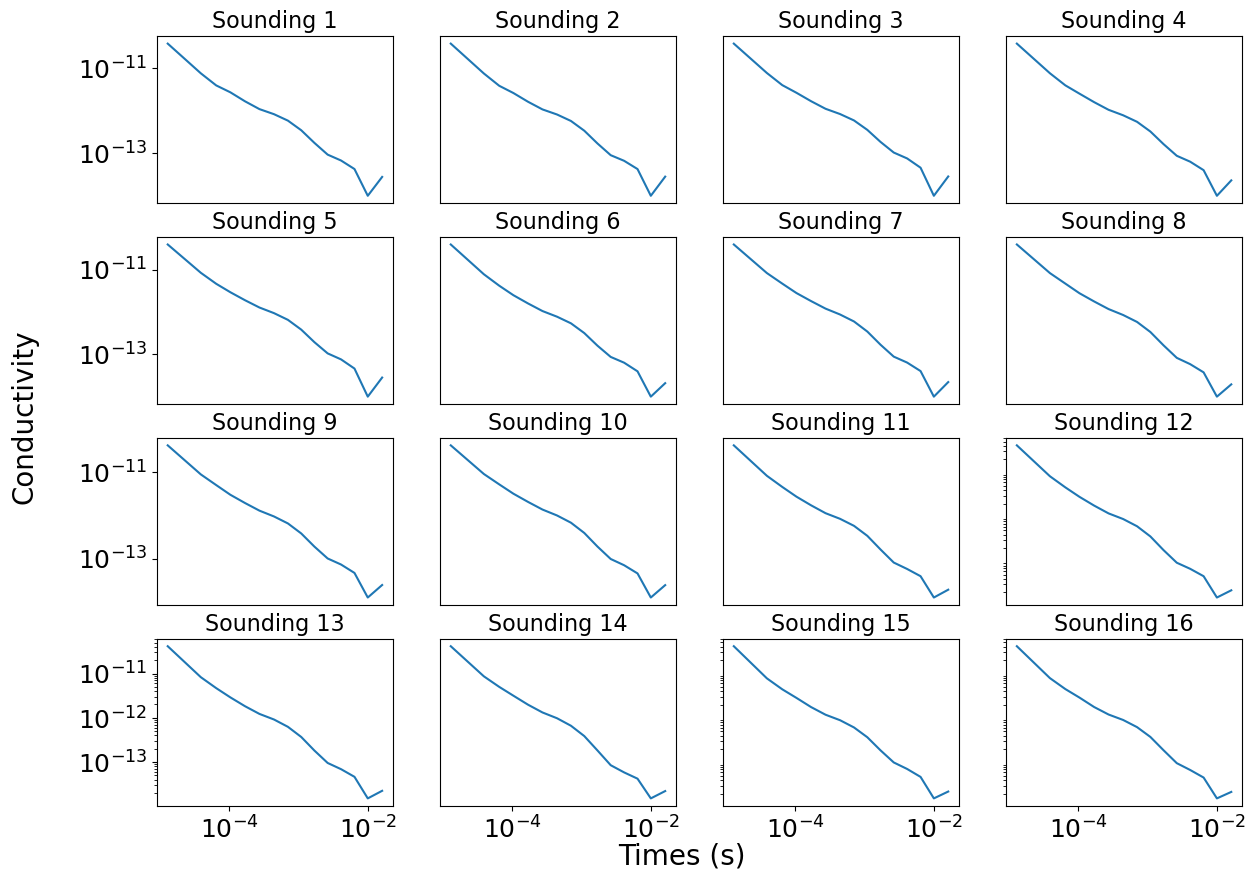

In [47]:
network.plot_residuals(latent=zmd, weighted=False)

# Randomize latent; does data still fit?

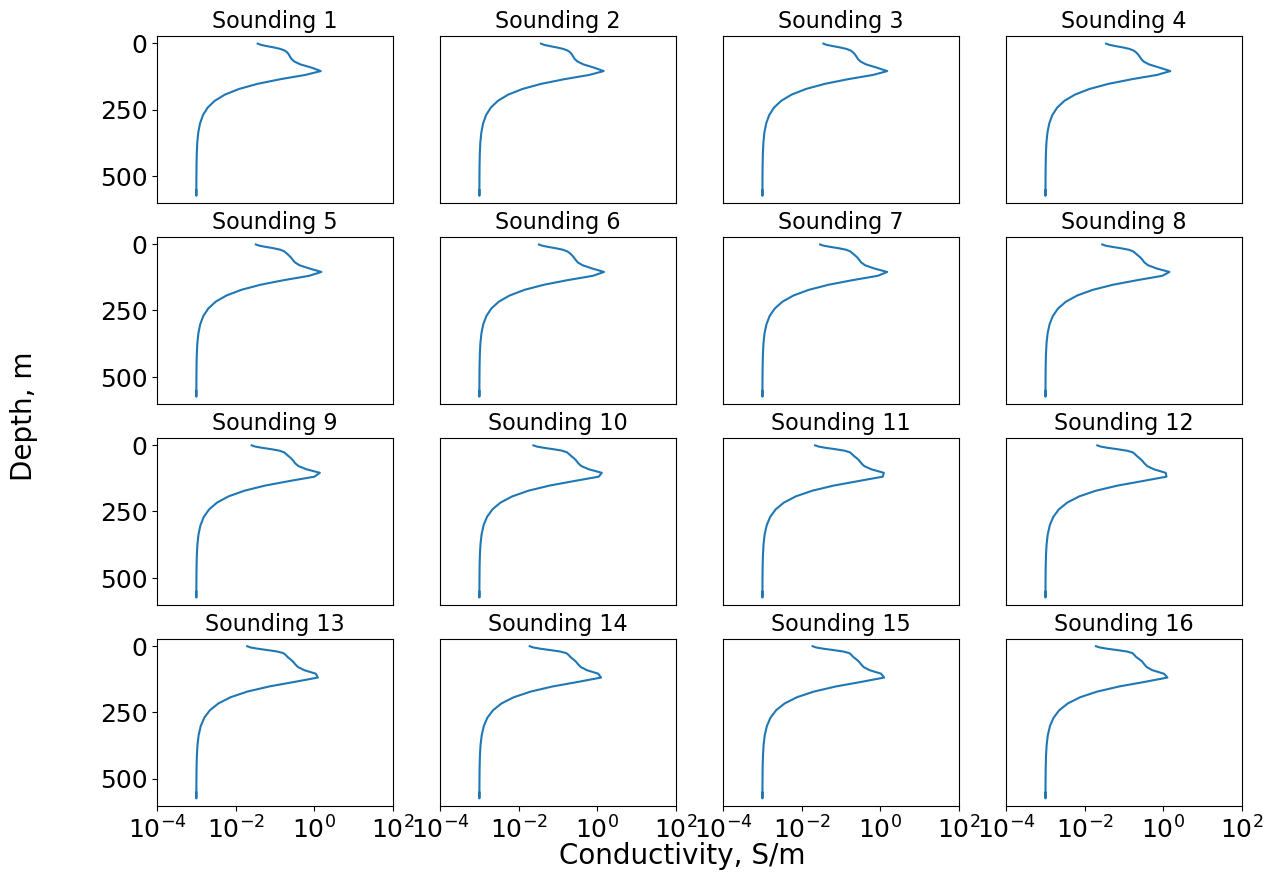

In [48]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test[0   :16])), depths=depths)

In [49]:
print(x_test[0:1,:,0].shape)
print(z_data[0:1].shape)

(1, 32)
(1, 16)


In [107]:
data0 = tf.tile(z_data[0:1],[16,1])
# print(latent_input)
data0 = tf.cast(data0, tf.float32)
# print(data0)
zmd2 = tf.concat((latent_input,data0),-1)
# print(zmd2)

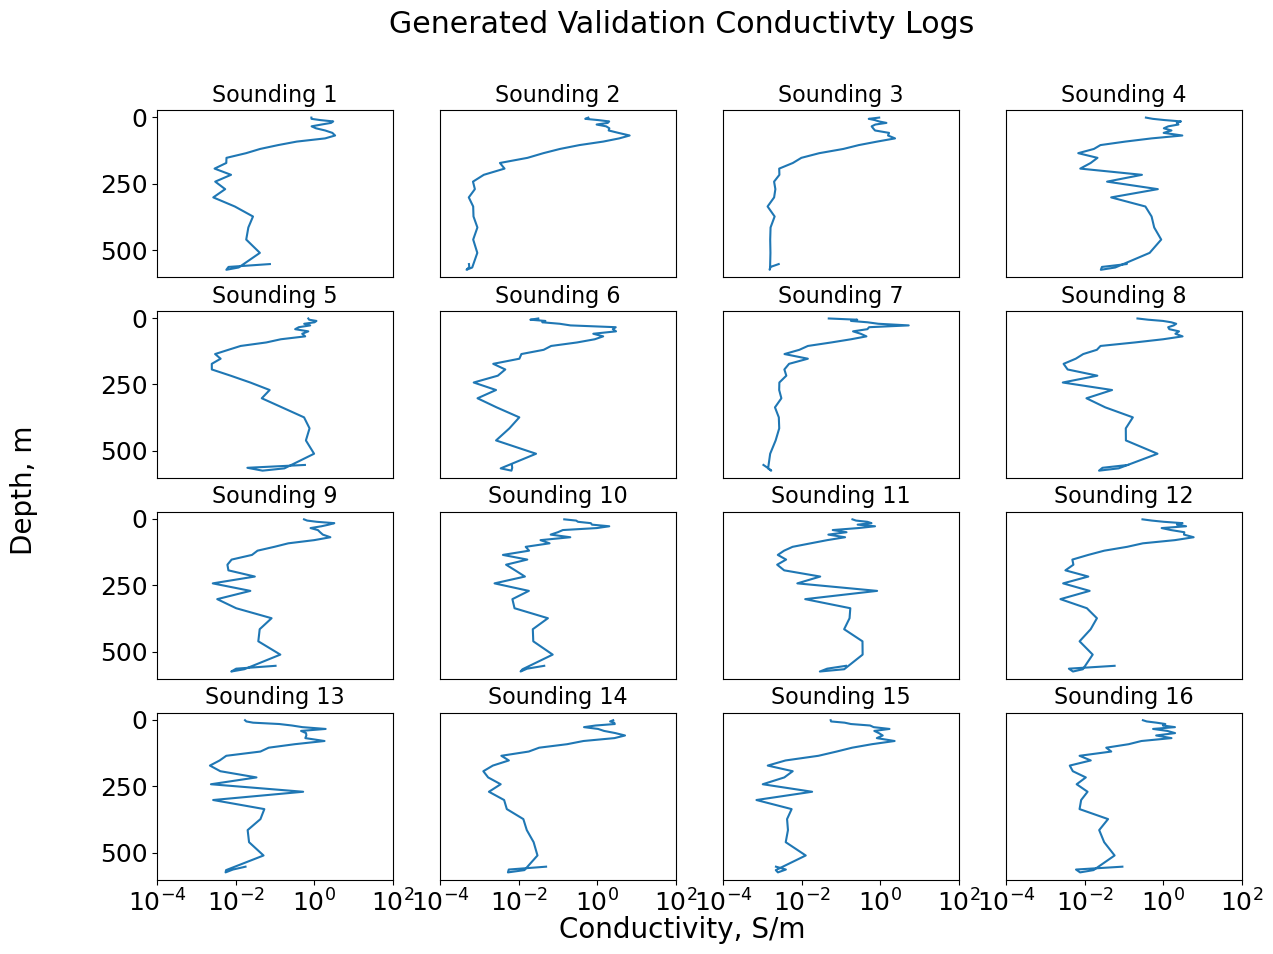

In [108]:
network.plot_models(latent=zmd2)

In [123]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = network.tanhs_to_model(zmd2_tanhs)
# zmd2 = (10**zmd2_logs)-1


true_test = tf.tile(x_test[0:1,:,0],[16,1])
true_test = tf.cast(true_test, tf.float32)
true_test1 = np.exp(network.tanhs_to_model(true_test))
# true_test1 = (10**true_test1)-1
print(true_test)

tf.Tensor(
[[-0.2588216  -0.244618   -0.21831214 -0.18539351 -0.15535384 -0.13544205
  -0.12411814 -0.11684808 -0.11126895 -0.10468572 -0.09149523 -0.06321242
  -0.01288369  0.02988796 -0.04074409 -0.15448967 -0.25950062 -0.3443917
  -0.4089282  -0.45572552 -0.4881533  -0.50958794 -0.523053   -0.531062
  -0.5355533  -0.5379176  -0.53908163 -0.5396157  -0.53984153 -0.5399217
  -0.53986543 -0.53989184]
 [-0.2588216  -0.244618   -0.21831214 -0.18539351 -0.15535384 -0.13544205
  -0.12411814 -0.11684808 -0.11126895 -0.10468572 -0.09149523 -0.06321242
  -0.01288369  0.02988796 -0.04074409 -0.15448967 -0.25950062 -0.3443917
  -0.4089282  -0.45572552 -0.4881533  -0.50958794 -0.523053   -0.531062
  -0.5355533  -0.5379176  -0.53908163 -0.5396157  -0.53984153 -0.5399217
  -0.53986543 -0.53989184]
 [-0.2588216  -0.244618   -0.21831214 -0.18539351 -0.15535384 -0.13544205
  -0.12411814 -0.11684808 -0.11126895 -0.10468572 -0.09149523 -0.06321242
  -0.01288369  0.02988796 -0.04074409 -0.15448967 -0.25

In [124]:
zmd2_logs.shape

(16, 32)

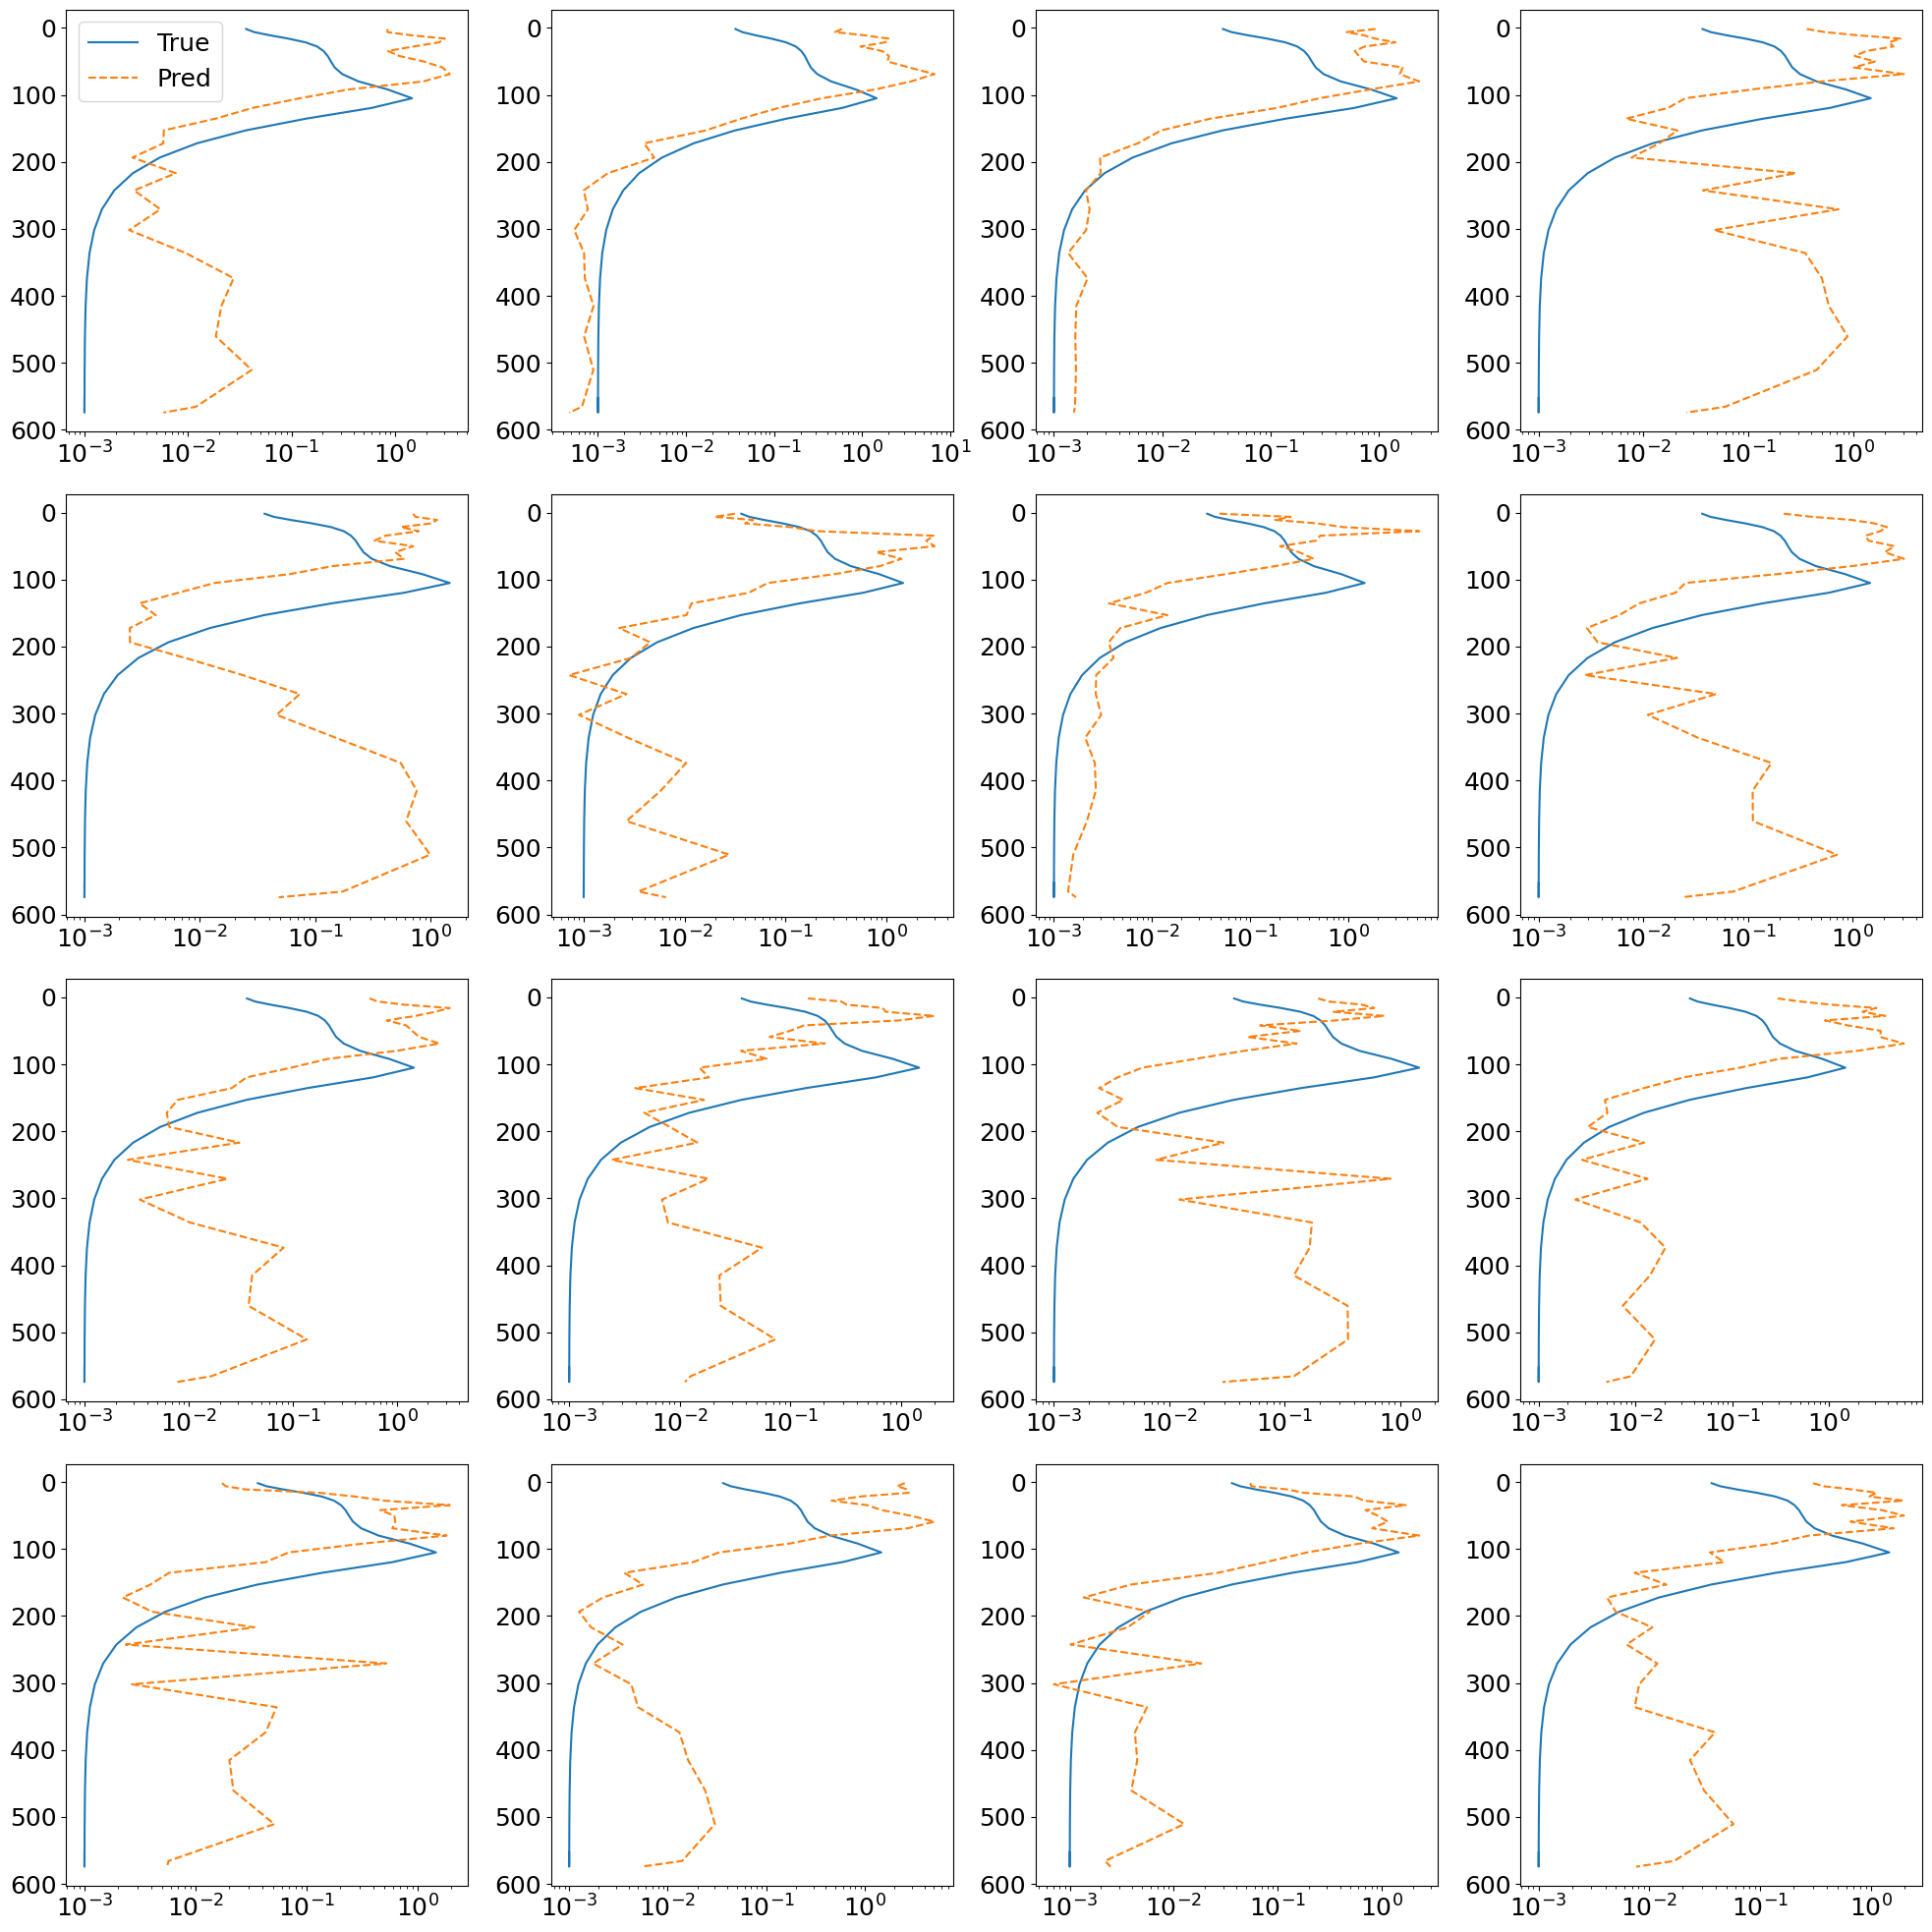

In [137]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_test1[i], plot_depths, label='True')
    plt.plot(np.exp(zmd2_logs[i][:-2]), plot_depths[:-2], label='Pred', linestyle='--')
    plt.xscale('log')
    # plt.plot(zmd2_logs[i], plot_depths, label='Pred_logs', linestyle='--')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

In [126]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
mean_true_cond = np.mean((AuEM_models3[0:3000,]), axis=0)
std_cond = np.std((zmd2_logs),axis=0)
print(std_cond)
print(mean_cond)
uncertainty = np.mean(mean_cond+std_cond**2)
print(np.exp(mean_cond)-std_cond)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

[1.3224378  1.2647338  1.2413193  1.2498593  0.90167636 0.81288403
 0.60739166 0.96844745 1.0787648  1.2889752  1.1144838  1.3798956
 1.0933688  1.1551087  0.94439965 0.8727982  0.5756485  0.5553578
 0.45394412 1.3326893  1.0486907  2.115629   1.2636895  1.7336748
 1.880954   1.8586684  2.0651038  2.0755992  1.5919894  1.1718295
 1.1526468  1.9605801 ]
[-1.4218613e+00 -1.2176689e+00 -7.0726132e-01 -1.2256208e-01
 -9.0542518e-02  1.4894721e-01 -6.6014327e-02 -3.0317837e-01
 -4.8960000e-04 -1.0959028e-01  2.8889501e-01 -5.1183939e-01
 -1.6646372e+00 -2.9941399e+00 -3.5995498e+00 -4.6976342e+00
 -4.8406215e+00 -5.5981469e+00 -5.5310817e+00 -4.6480317e+00
 -5.7357302e+00 -4.0012045e+00 -5.4779754e+00 -4.4332938e+00
 -3.6181424e+00 -3.8716066e+00 -3.8820429e+00 -3.2076273e+00
 -4.5372410e+00 -5.0417633e+00 -4.9715590e+00 -3.6542971e+00]
[-1.0811732  -0.9688146  -0.7483268  -0.3652084   0.0117591   0.34772772
  0.3287258  -0.22998011 -0.07925427 -0.392774    0.2204678  -0.7805035
 -0.9041095

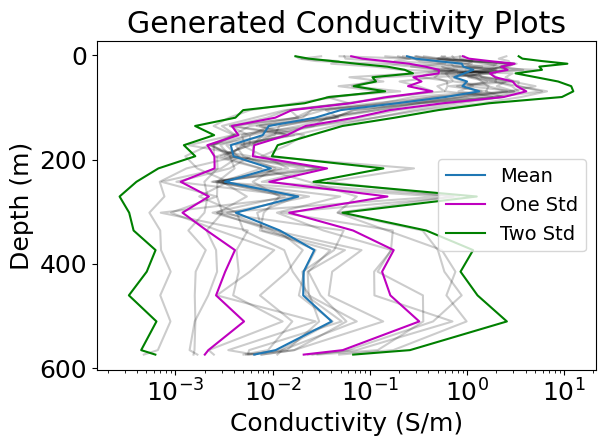

In [135]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.plot(np.exp(log[:-2]), plot_depths[:-2], c='k', alpha=0.2)
ax.plot(np.exp(mean_cond[:-2]), plot_depths[:-2],label='Mean')
ax.plot(np.exp(mean_cond[:-2]+std_cond[:-2]),plot_depths[:-2], c='m', label="One Std")
ax.plot(np.exp(mean_cond[:-2]-std_cond[:-2]), plot_depths[:-2], c='m')
ax.plot(np.exp(mean_cond[:-2]+2*std_cond[:-2]), plot_depths[:-2], c='g', label= 'Two Std') # type: ignore
ax.plot(np.exp(mean_cond[:-2]-2*std_cond[:-2]), plot_depths[:-2], c='g')
# ax.plot(true_test1[1],plot_depths, c='orange', label = 'True Mean')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xscale('log')
# ax.axes.set_xlim(1e-1, 1e3)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()



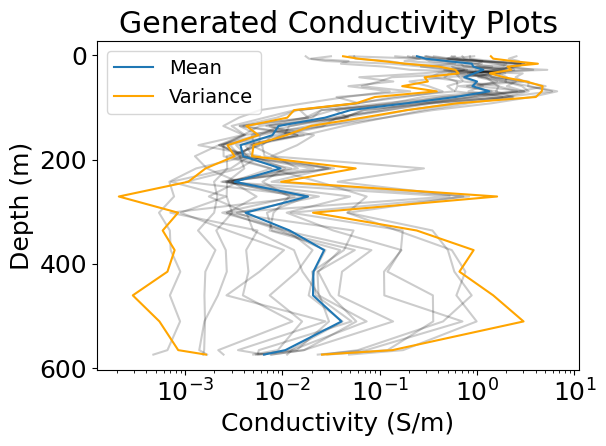

In [141]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(np.exp(log)[:-2], plot_depths[:-2], c='k', alpha=0.2)
ax.semilogx(np.exp(mean_cond)[:-2], plot_depths[:-2],label='Mean')
ax.semilogx(np.exp(mean_cond+std_cond**2)[:-2], plot_depths[:-2], c='orange', label='Variance')
ax.semilogx(np.exp(mean_cond-std_cond**2)[:-2], plot_depths[:-2], c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
# ax.axes.set_xlim(1e-4, 1e5)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

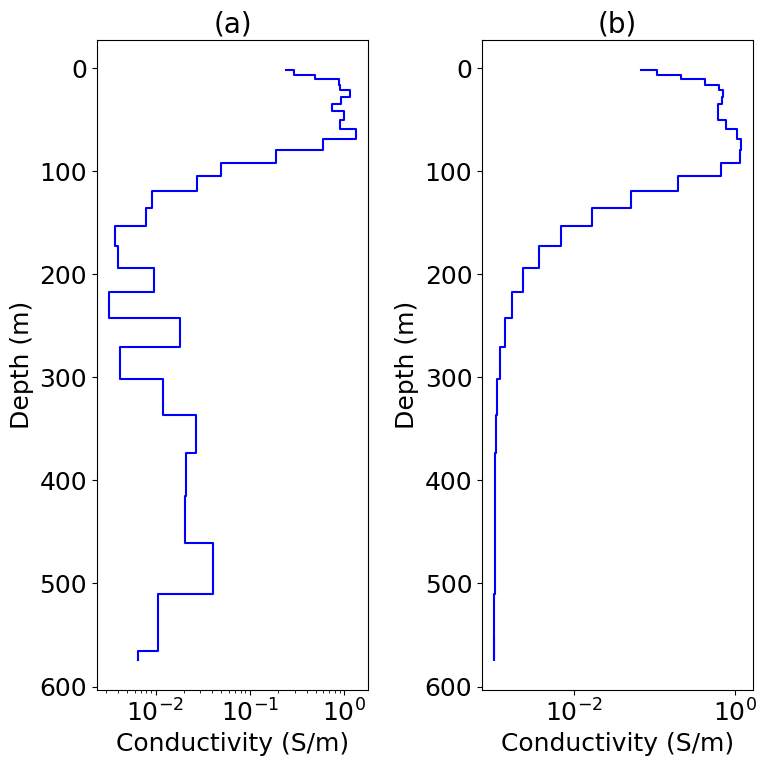

In [133]:
# # Example inputs
# conductivities = [0.01, 0.1, 0.05, 0.2, 0.01]  # Conductivity (S/m) for each layer
# thicknesses = [10, 20, 20, 30, 20]  # Thickness of each layer (m)

# # Compute depths from thicknesses
# depths = np.cumsum(thicknesses)  # Compute layer boundaries
# depths = np.insert(depths, 0, 0)  # Insert surface depth at 0

# # Create step-like depth and conductivity arrays
# depth_plot = np.repeat(plot_depths, 2)  # Duplicate depths for step changes
# conductivity_plot = np.repeat(zmd2_logs[0], 2)  # Duplicate conductivity values

depth_plot = np.repeat(plot_depths, 2)
# depth_plot=np.flip(depth_plot)

fig, ax = plt.subplots(1,2,figsize=(8, 8))

# plt.ticklabel_format(axis='y', style='sci', scilimits=(4, 4))
# fig.suptitle('VAE Generated Models')
for log in zmd2:
    conductivity_plot = np.repeat(log,2)
    # ax[0].semilogx(conductivity_plot, depth_plot, drawstyle='steps-post', color='k', alpha=0.2)

# for i in AuEM_models3[0:1000,]:
    # ax[1].semilogx(i, plot_depths, drawstyle='steps-post', color='k', alpha=0.2)

mean_cond_plot = np.repeat(mean_cond,2)
mean_true_cond_plot = np.repeat(mean_true_cond,2)
ax[0].semilogx(np.exp(mean_cond[:-2]),plot_depths[:-2], drawstyle='steps-post', c='b', label='Mean')
# ax.plot(mean_true_cond_plot, depth_plot, drawstyle='steps-post', c='r', label='True Mean')
ax[0].invert_yaxis()
# ax[0].invert_xaxis()
# Labels and title
ax[0].set_xscale('log')
ax[0].set_xlabel('Conductivity (S/m)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('(a)', fontsize=20)
# ax[0].legend()
ax[1].semilogx(mean_true_cond_plot, depth_plot, drawstyle='steps-post', c='b', label='Mean')
ax[1].invert_yaxis()
# Labels and title
# ax[1].set_xscale('log')
ax[1].set_xlabel('Conductivity (S/m)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_title('(b)', fontsize=20)
# plt.grid()
plt.tight_layout()
plt.savefig('Comparison_GeneratedvsTrue.jpg')
plt.show()


In [59]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [60]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [61]:
# network.plot_residuals(latent=zmd2, weighted=True)

In [62]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [63]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [64]:
network.data_weights

array([[[  6.13753404],
        [  7.3079499 ],
        [ 10.83226511],
        [ 23.64976661],
        [560.71538076],
        [ 50.93441952],
        [ 39.71250822],
        [ 34.74909777],
        [ 25.35728873],
        [ 19.43811575],
        [ 20.11087467],
        [ 55.99925511],
        [ 18.60646586],
        [  6.83536963],
        [  4.22542972],
        [  3.17732833],
        [  2.6435149 ],
        [  2.33710856],
        [  2.15005994],
        [  2.03276927],
        [  1.9589534 ],
        [  1.91312864],
        [  1.88546542],
        [  1.86940985],
        [  1.8605376 ],
        [  1.85590815],
        [  1.85364244],
        [  1.85261005],
        [  1.85218334],
        [  1.8520607 ],
        [  1.85214682],
        [  1.85210642]]])

# Sample latent & different data soundings

In [65]:
# Plot true models for comparisons - need models for line 94 and adjust plot_logs to show true models too

data_batch = raw_test_data94[0:16]
latent_dim = 20  # known from model
latent_input = tf.random.normal((16, latent_dim))

In [66]:
zmd3 = tf.concat(((latent_input), data_batch), -1)
print(zmd3.shape)

(16, 36)


In [148]:
zmd3_tanhs = network.decode(zmd3, apply_tanh=True)
zmd3_samples = zmd3_tanhs.shape[0]
zmd3_tanhs = np.reshape(zmd3_tanhs, (zmd3_samples, network.n_model))
zmd3_logs = network.tanhs_to_model(zmd3_tanhs)
# zmd3_exp = (10**zmd3_logs)

In [149]:
true_models = x_test94[0:16]
true_logs = np.exp(network.tanhs_to_model(true_models))
true_models = (10**true_logs)
print(true_logs)

[[[0.027579  ]
  [0.037342  ]
  [0.067776  ]
  [0.146918  ]
  [0.251119  ]
  [0.229682  ]
  [0.14683   ]
  [0.088529  ]
  [0.057504  ]
  [0.042529  ]
  [0.037071  ]
  [0.039304  ]
  [0.051884  ]
  [0.081916  ]
  [0.119985  ]
  [0.10514   ]
  [0.053187  ]
  [0.021801  ]
  [0.009363  ]
  [0.00468   ]
  [0.002776  ]
  [0.001918  ]
  [0.001498  ]
  [0.001279  ]
  [0.001162  ]
  [0.001097  ]
  [0.001061  ]
  [0.001041  ]
  [0.001032  ]
  [0.001035  ]
  [0.00103289]
  [0.00103388]]

 [[0.029698  ]
  [0.03982   ]
  [0.070956  ]
  [0.149919  ]
  [0.248876  ]
  [0.2255    ]
  [0.145899  ]
  [0.08963   ]
  [0.05924   ]
  [0.044361  ]
  [0.038878  ]
  [0.041084  ]
  [0.053556  ]
  [0.083058  ]
  [0.119278  ]
  [0.101671  ]
  [0.050365  ]
  [0.020533  ]
  [0.008863  ]
  [0.004471  ]
  [0.002678  ]
  [0.001867  ]
  [0.001469  ]
  [0.001261  ]
  [0.001149  ]
  [0.001088  ]
  [0.001055  ]
  [0.001036  ]
  [0.001028  ]
  [0.00103   ]
  [0.0010286 ]
  [0.00102925]]

 [[0.030611  ]
  [0.041253  ]
  [0.0

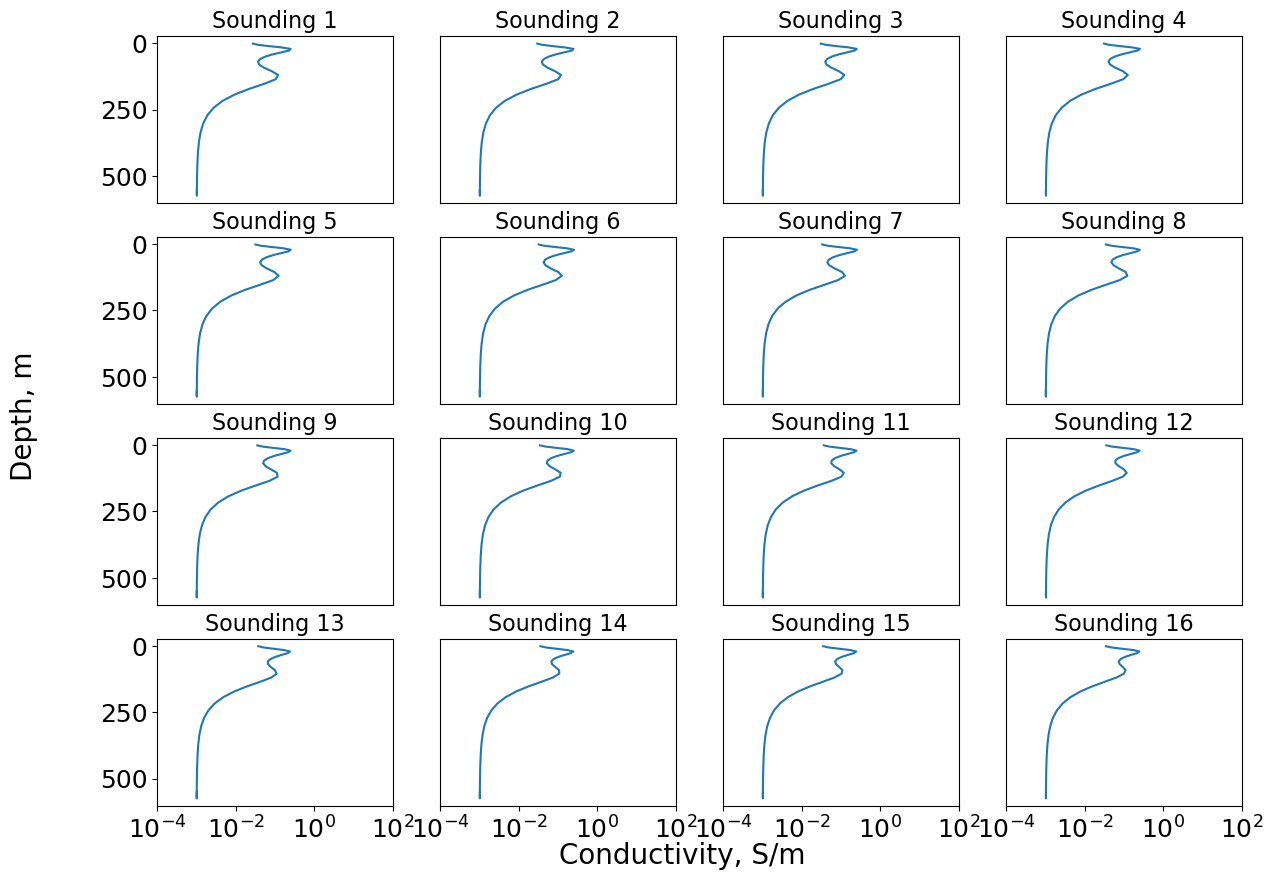

In [150]:
vae.plot_logs(true_logs, depths=depths)

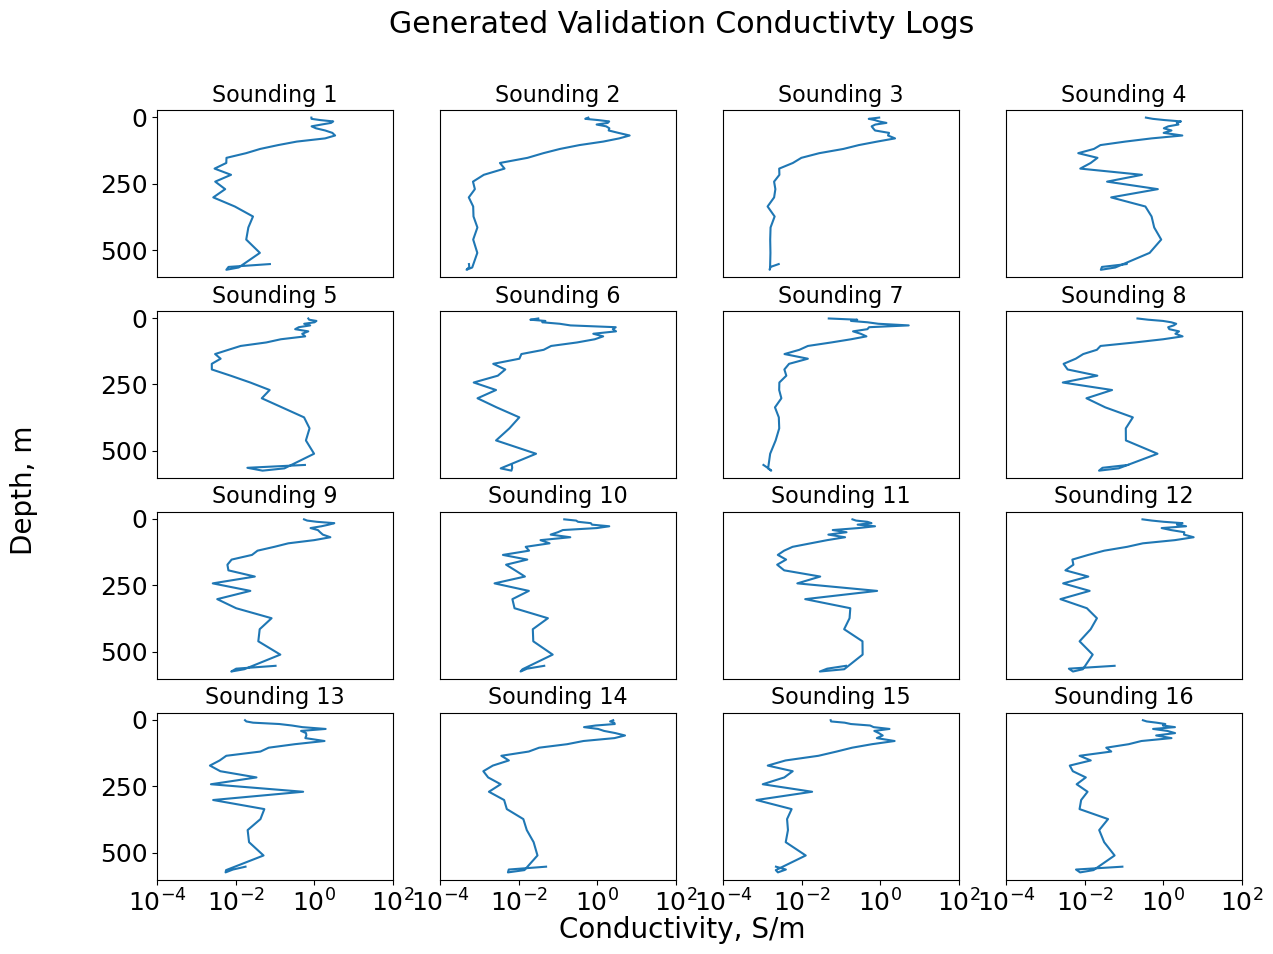

In [151]:
network.plot_models(latent=zmd3)

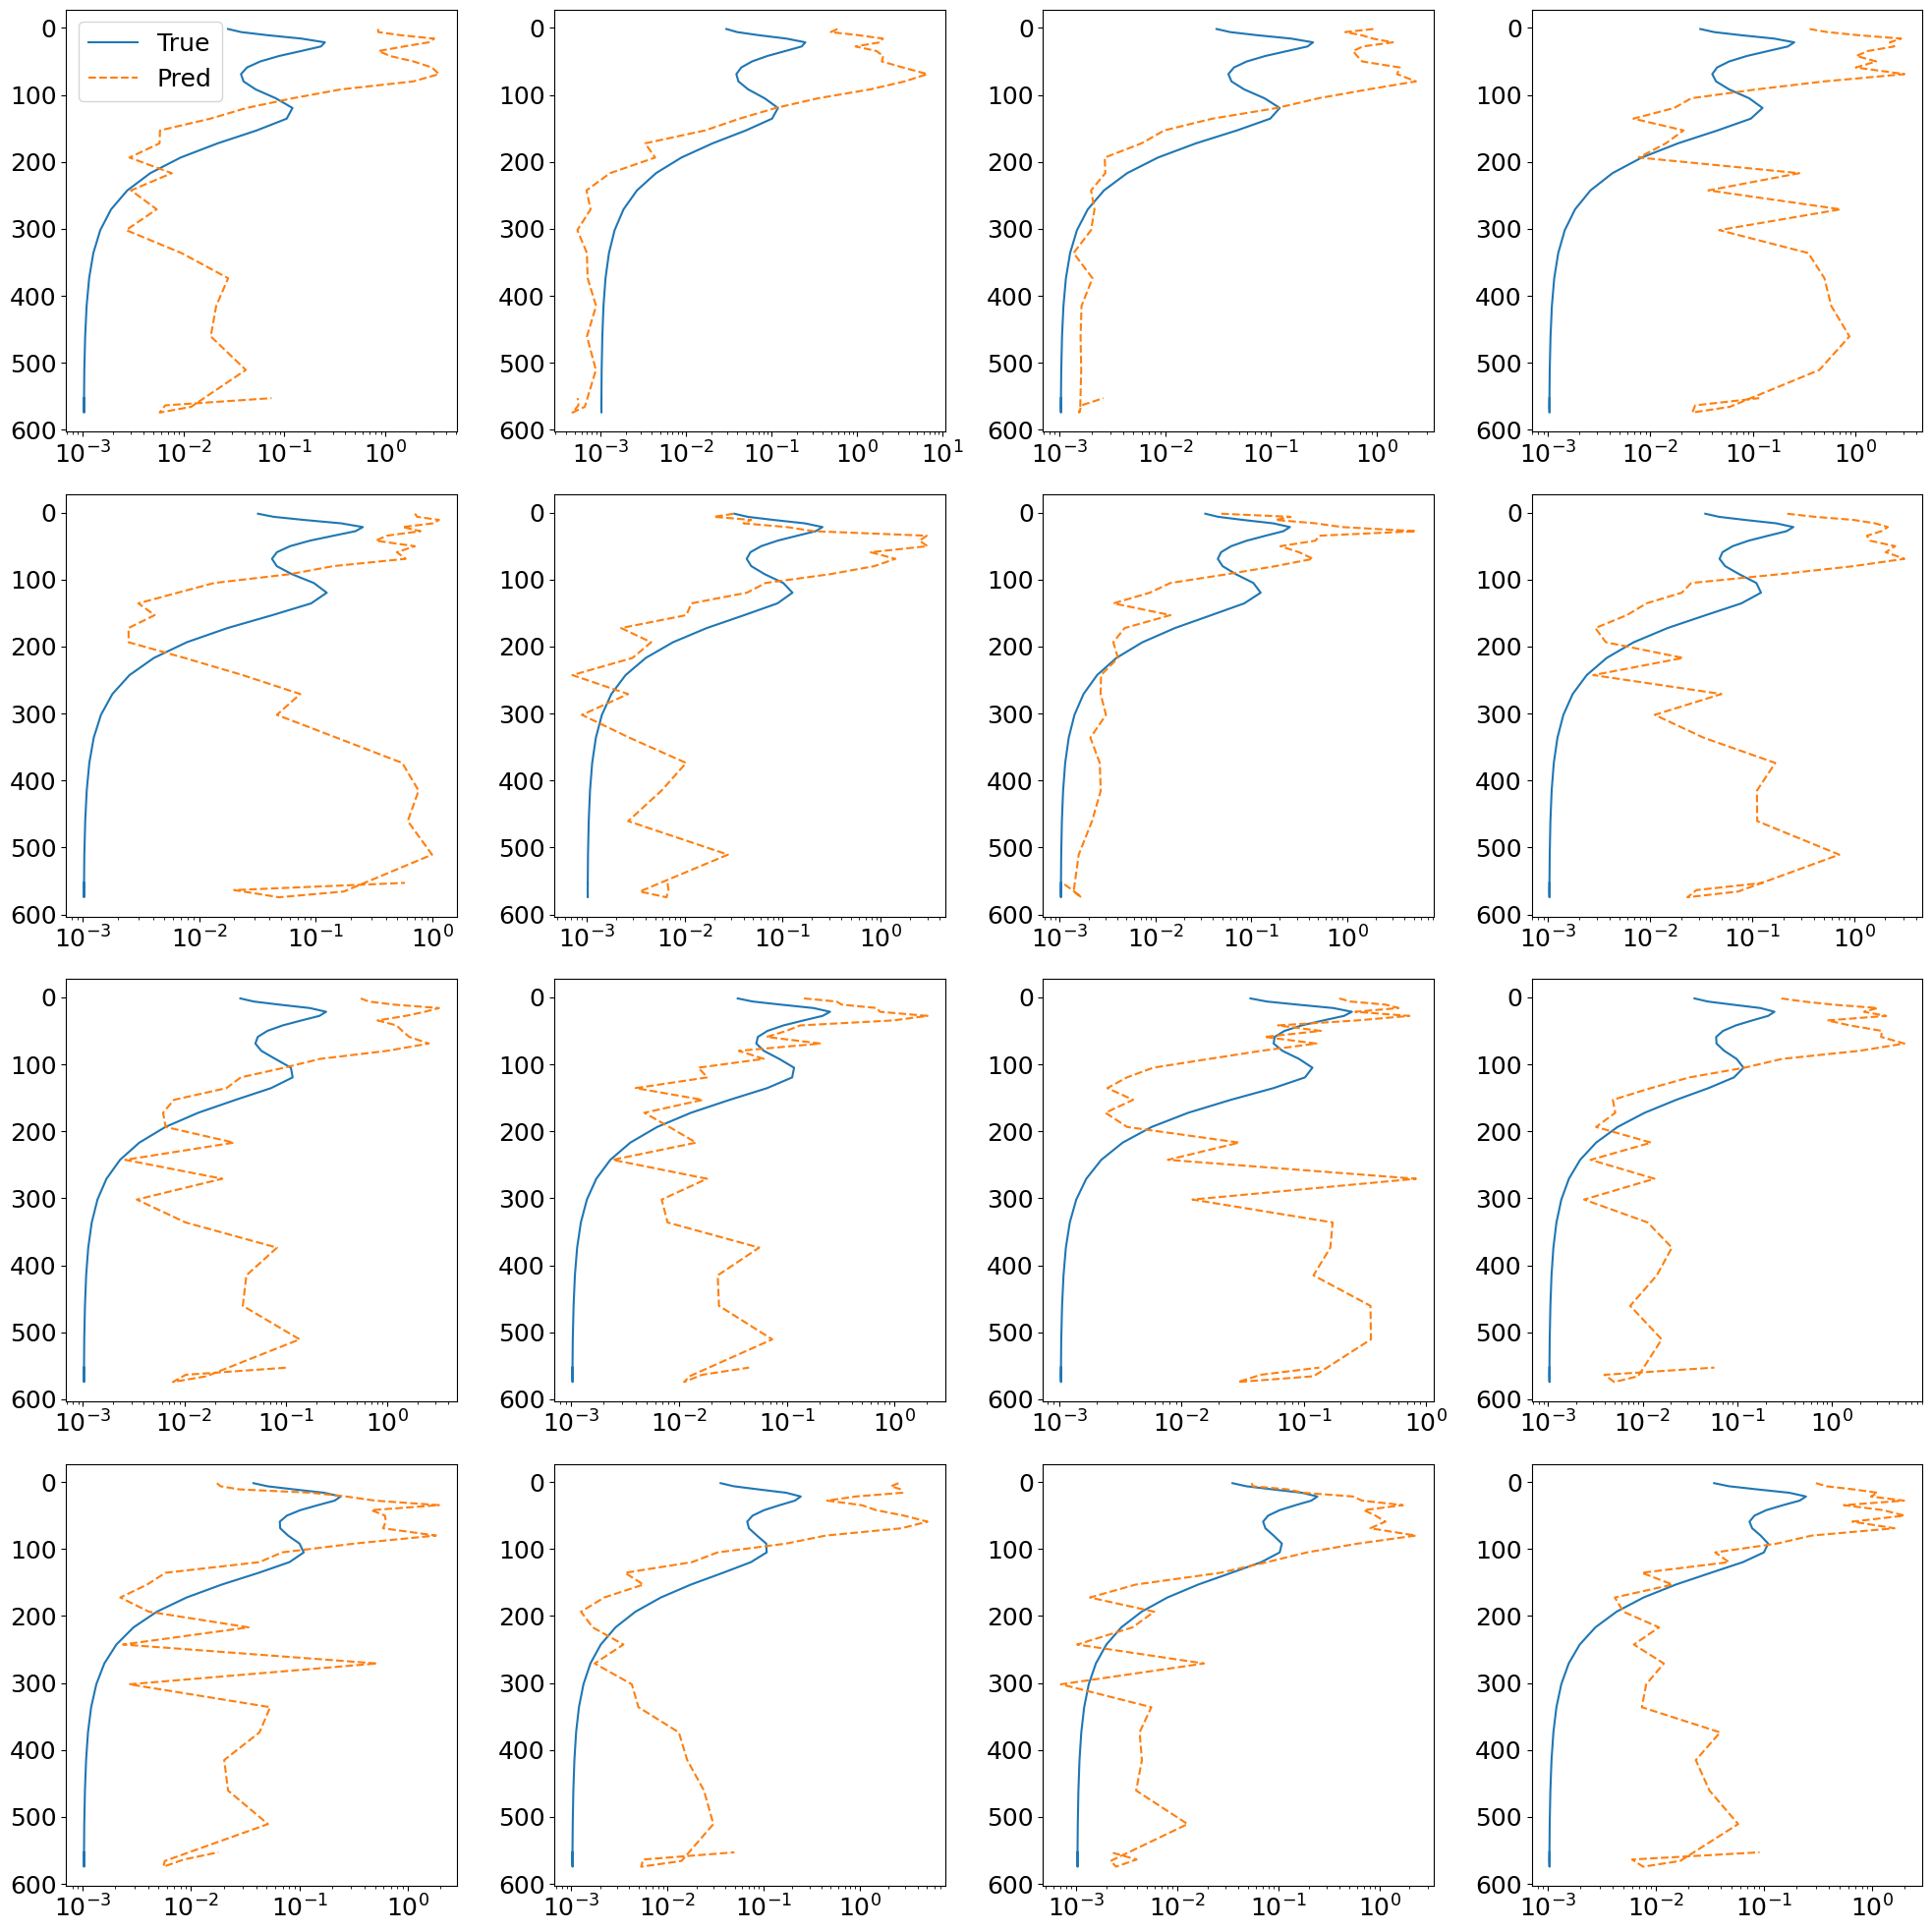

In [152]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_logs[i], plot_depths, label='True')
    plt.plot(np.exp(zmd3_logs[i]), plot_depths, label='Pred', linestyle='--')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

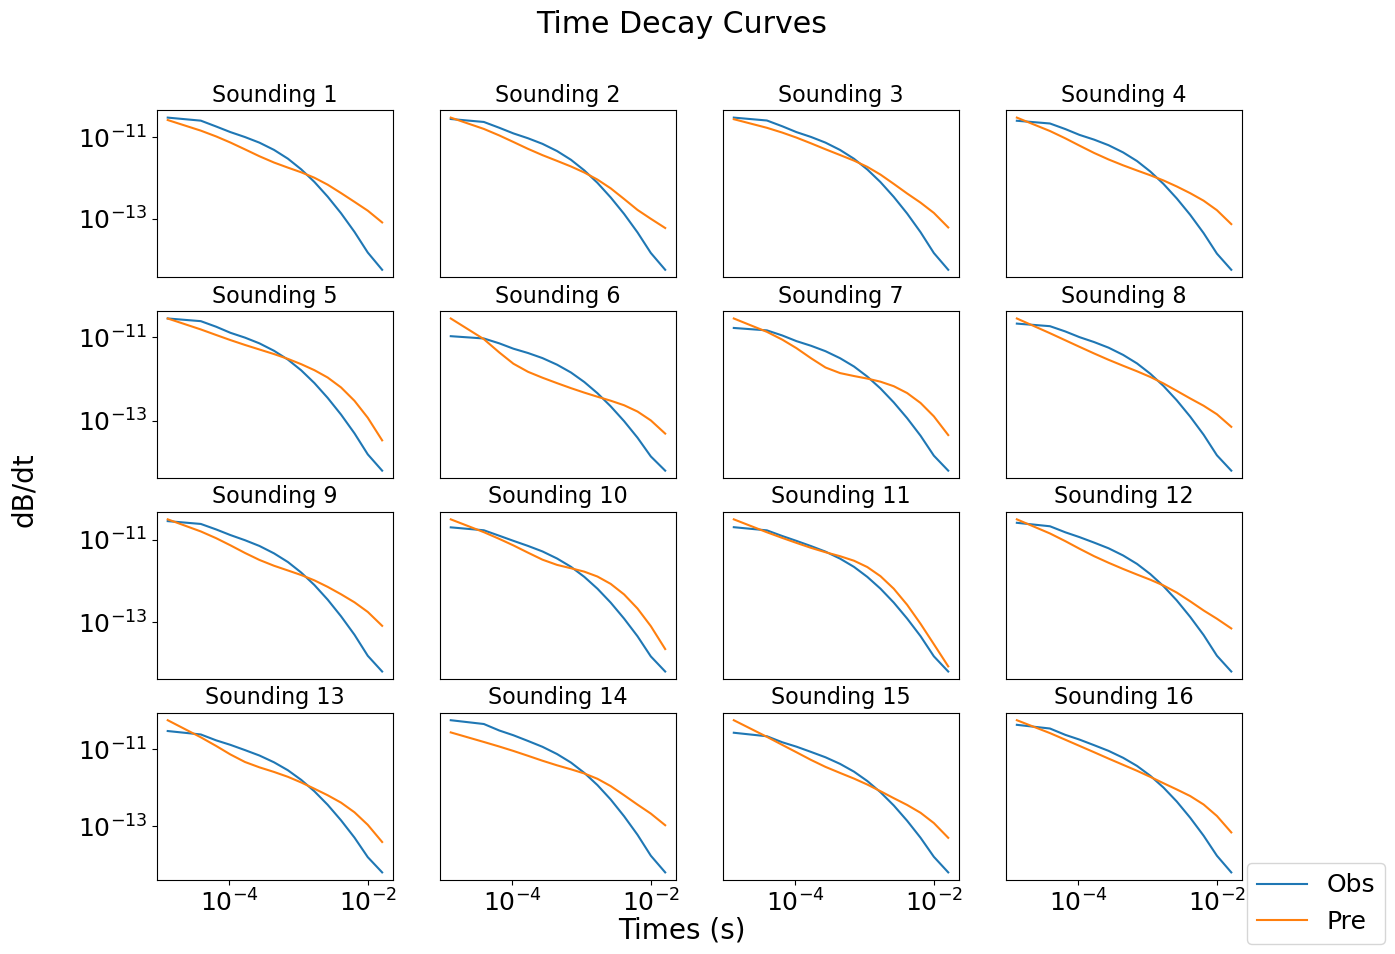

In [153]:
network.plot_data(latent=zmd3)
# Why only one sounding???

In [154]:
# zmd3_tanhs = network.decode(zmd3, apply_tanh=True)
# zmd3_samples = zmd3_tanhs.shape[0]
# zmd3_tanhs = np.reshape(zmd3_tanhs, (zmd3_samples, network.n_model))
# zmd3_logs = np.exp(network.tanhs_to_model(zmd3_tanhs))
# zmd3_exp = (10**zmd3_logs)

d_obs: (16, 16)
d_pre: (16, 16)
data_std: (1, 32, 1)
n_time: 16
d_std: (1, 16)
data tf.Tensor(
[[-6.19139234e-13 -1.48051374e-12 -7.15368736e-13 -2.48143140e-13
  -8.90676489e-15 -7.66106200e-14 -6.22465065e-14 -3.36263847e-14
  -9.75146172e-15 -1.09500091e-14 -1.67068897e-14 -5.17975470e-15
  -1.14434846e-14 -2.10382029e-14 -1.80604534e-14 -2.40148664e-14]
 [-3.98316308e-13 -1.11442919e-12 -5.85631261e-13 -2.13292288e-13
  -7.99910980e-15 -6.73045942e-14 -5.18761263e-14 -2.66987987e-14
  -7.24639143e-15 -8.36034648e-15 -1.17369764e-14 -3.26870311e-15
  -6.68504702e-15 -1.30999329e-14 -1.33381084e-14 -1.77358365e-14]
 [-4.03070074e-13 -1.13867607e-12 -4.92975181e-13 -1.45195840e-13
  -5.29891064e-15 -4.39655907e-14 -2.98874695e-14 -8.24430635e-15
  -9.97219427e-15 -2.13809005e-14 -1.85624458e-14 -5.08238488e-15
  -1.10290551e-14 -1.87204056e-14 -1.36427370e-14 -1.81400034e-14]
 [-9.17905183e-13 -1.17285944e-12 -6.78330872e-13 -2.49014053e-13
  -9.33617163e-15 -7.82734676e-14 -6.2445898

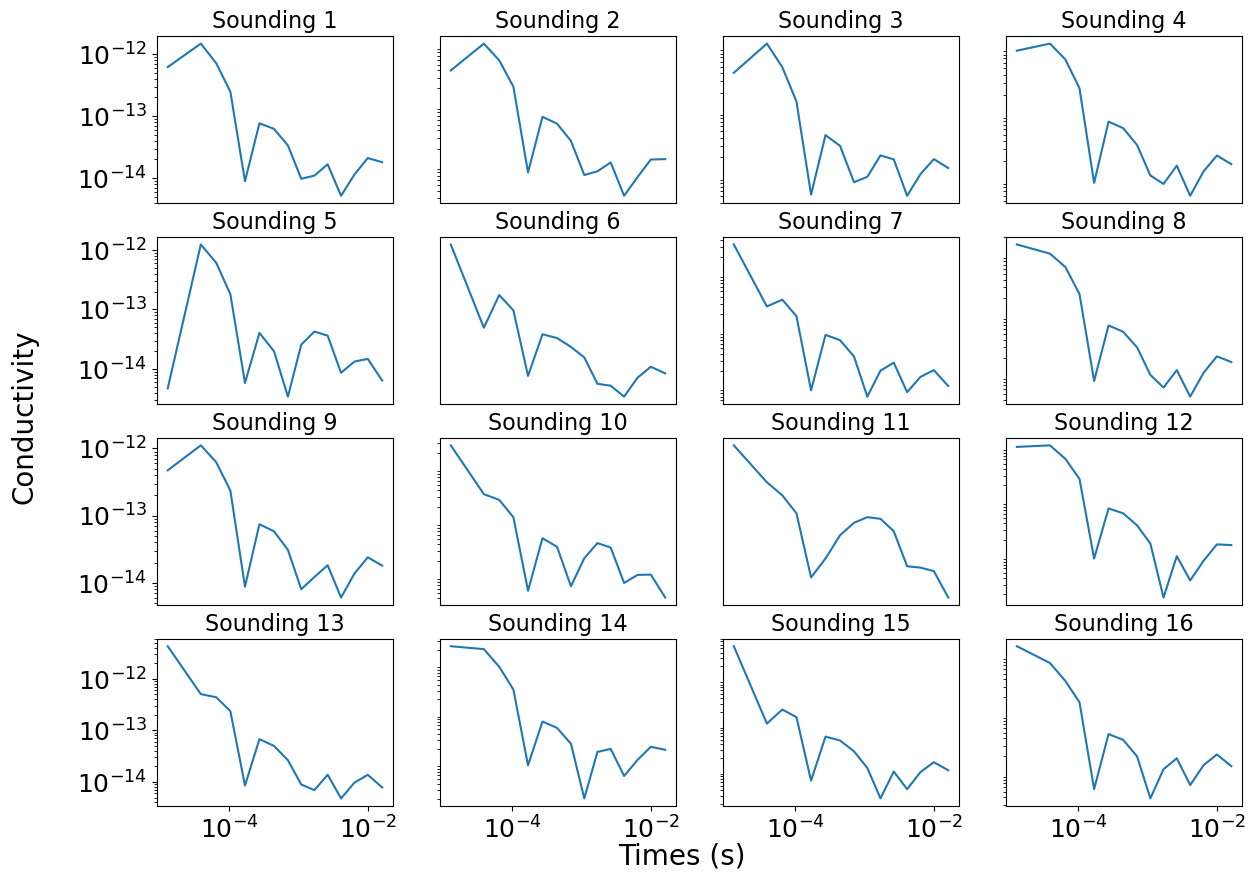

In [155]:
network.plot_residuals(latent=zmd3)